# Credit Card Users Churn Prediction

## Problem Statement

### Business Context

The bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged to every user irrespective of usage, while others are charged under specified circumstances.

Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas

I need to come up with a classification model that will help the bank improve its services so that customers do not renounce their credit cards

### Data Description

* CLIENTNUM: Client number. Unique identifier for the customer holding the account
* Attrition_Flag: Internal event (customer activity) variable - if the account is closed then "Attrited Customer" else "Existing Customer"
* Customer_Age: Age in Years
* Gender: Gender of the account holder
* Dependent_count: Number of dependents
* Education_Level: Educational Qualification of the account holder - Graduate, High School, Unknown, Uneducated, College(refers to college student), Post-Graduate, Doctorate
* Marital_Status: Marital Status of the account holder
* Income_Category: Annual Income Category of the account holder
* Card_Category: Type of Card
* Months_on_book: Period of relationship with the bank (in months)
* Total_Relationship_Count: Total no. of products held by the customer
* Months_Inactive_12_mon: No. of months inactive in the last 12 months
* Contacts_Count_12_mon: No. of Contacts in the last 12 months
* Credit_Limit: Credit Limit on the Credit Card
* Total_Revolving_Bal: Total Revolving Balance on the Credit Card
* Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months)
* Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1)
* Total_Trans_Amt: Total Transaction Amount (Last 12 months)
* Total_Trans_Ct: Total Transaction Count (Last 12 months)
* Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1)
* Avg_Utilization_Ratio: Average Card Utilization Ratio

#### What Is a Revolving Balance?

- If we don't pay the balance of the revolving credit account in full every month, the unpaid portion carries over to the next month. That's called a revolving balance


##### What is the Average Open to buy?

- 'Open to Buy' means the amount left on your credit card to use. Now, this column represents the average of this value for the last 12 months.

##### What is the Average utilization Ratio?

- The Avg_Utilization_Ratio represents how much of the available credit the customer spent. This is useful for calculating credit scores.


##### Relation b/w Avg_Open_To_Buy, Credit_Limit and Avg_Utilization_Ratio:

- ( Avg_Open_To_Buy / Credit_Limit ) + Avg_Utilization_Ratio = 1

## Importing necessary libraries

In [ ]:
#install XGBoost
##!pip install 'neptune-contrib[monitoring]>=0.24.9'

##import neptune
##import xgboost as xgb
##import pandas as pd


# here you import `neptune_calback` that does the magic (the open source magic :)
##from neptunecontrib.monitoring.xgboost_monitor import neptune_callback

##!pip install imblearn --user
##!pip install imbalanced-learn --user

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import scipy.stats as stats
from sklearn import tree
from sklearn import metrics

#to help with model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV #for data tuning
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score #see how good the model is
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression

#To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder


import warnings
warnings.filterwarnings('ignore')

#to impute missing values, tool from sklearn to replace nan/na with strategy: mean/median/most_frequent
from sklearn.impute import SimpleImputer

#to undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#to define max number of columns to be displayed for a dataframe
pd.set_option('display.float_format',lambda x: '%.3f' % x)

#to supress scientific notation for a dataframe
pd.set_option ('display.float_format',lambda x: '%.3f'% x)

Mounted at /content/drive


## Loading the dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/CreditCard_project_boostingbagging/BankChurners.csv')

In [ ]:
data=df.copy()

## Data Overview

- Observations
- Sanity checks

In [ ]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.000,777,11914.000,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.000,864,7392.000,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.000,0,3418.000,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,...,4,1,3313.000,2517,796.000,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.000,0,4716.000,2.175,816,28,2.500,0.000


In [ ]:
data.shape

(10127, 21)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   object 
 6   Marital_Status            9378 non-null   object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

missing values
- education level
- marital status

In [ ]:
#check missing values in percentage in the data
#,2 rounded to 2 decimels
round(data.isnull().sum()/data.isnull().count()*100,2)

CLIENTNUM                   0.000
Attrition_Flag              0.000
Customer_Age                0.000
Gender                      0.000
Dependent_count             0.000
Education_Level            15.000
Marital_Status              7.400
Income_Category             0.000
Card_Category               0.000
Months_on_book              0.000
Total_Relationship_Count    0.000
Months_Inactive_12_mon      0.000
Contacts_Count_12_mon       0.000
Credit_Limit                0.000
Total_Revolving_Bal         0.000
Avg_Open_To_Buy             0.000
Total_Amt_Chng_Q4_Q1        0.000
Total_Trans_Amt             0.000
Total_Trans_Ct              0.000
Total_Ct_Chng_Q4_Q1         0.000
Avg_Utilization_Ratio       0.000
dtype: float64

In [ ]:
data.duplicated().sum()

0

converting 'objects' to 'category' reduces the data space required to store the dataframe

In [ ]:
#fixing the datatype
cols=data.select_dtypes(['object'])
cols.columns

Index(['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category'],
      dtype='object')

In [ ]:
for i in cols.columns:
  data[i]=data[i].astype('category')

- object datatype cannot be used to run the model

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CLIENTNUM                 10127 non-null  int64   
 1   Attrition_Flag            10127 non-null  category
 2   Customer_Age              10127 non-null  int64   
 3   Gender                    10127 non-null  category
 4   Dependent_count           10127 non-null  int64   
 5   Education_Level           8608 non-null   category
 6   Marital_Status            9378 non-null   category
 7   Income_Category           10127 non-null  category
 8   Card_Category             10127 non-null  category
 9   Months_on_book            10127 non-null  int64   
 10  Total_Relationship_Count  10127 non-null  int64   
 11  Months_Inactive_12_mon    10127 non-null  int64   
 12  Contacts_Count_12_mon     10127 non-null  int64   
 13  Credit_Limit              10127 non-null  floa

In [ ]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.000,NaN,NaN,NaN,739177606.334,36903783.450,708082083.000,713036770.500,717926358.000,773143533.000,828343083.000
Attrition_Flag,10127,2,Existing Customer,8500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_Age,10127.000,NaN,NaN,NaN,46.326,8.017,26.000,41.000,46.000,52.000,73.000
Gender,10127,2,F,5358,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependent_count,10127.000,NaN,NaN,NaN,2.346,1.299,0.000,1.000,2.000,3.000,5.000
Education_Level,8608,6,Graduate,3128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,9378,3,Married,4687,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income_Category,10127,6,Less than $40K,3561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Card_Category,10127,4,Blue,9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Months_on_book,10127.000,NaN,NaN,NaN,35.928,7.986,13.000,31.000,36.000,40.000,56.000


In [ ]:
data.describe(include=['category']).T

,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Gender,10127,2,F,5358
Education_Level,8608,6,Graduate,3128
Marital_Status,9378,3,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


In [ ]:
data.drop(['CLIENTNUM'],axis=1,inplace=True) #axis=1: look from the columns and drop the variable, if not default will be looking into index

In [ ]:
#purpose: to convert into numerical for analysis purpose for imputation
#1: as defaulters/attrited
data['Attrition_Flag'].replace('Existing Customer',0,inplace=True)
data['Attrition_Flag'].replace('Attrited Customer',1,inplace=True)

In [ ]:
col_cats=data.select_dtypes(['category'])

In [ ]:
#to identify all possible answers in the variables
for i in col_cats.columns:
    print('Unique values in',i,'are:')
    print(col_cats[i].value_counts(dropna=False)) #dropna: if any missing values will also count into
    print('*'*50)

Unique values in Attrition_Flag are:
0    8500
1    1627
Name: Attrition_Flag, dtype: int64
**************************************************
Unique values in Gender are:
F    5358
M    4769
Name: Gender, dtype: int64
**************************************************
Unique values in Education_Level are:
Graduate         3128
High School      2013
NaN              1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
**************************************************
Unique values in Marital_Status are:
Married     4687
Single      3943
NaN          749
Divorced     748
Name: Marital_Status, dtype: int64
**************************************************
Unique values in Income_Category are:
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64
************************************************

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.

**Questions**:

1. How is the total transaction amount distributed?
2. What is the distribution of the level of education of customers?
3. What is the distribution of the level of income of customers?
4. How does the change in transaction amount between Q4 and Q1 (`total_ct_change_Q4_Q1`) vary by the customer's account status (`Attrition_Flag`)?
5. How does the number of months a customer was inactive in the last 12 months (`Months_Inactive_12_mon`) vary by the customer's account status (`Attrition_Flag`)?
6. What are the attributes that have a strong correlation with each other?



#### The below functions need to be defined to carry out the Exploratory Data Analysis.

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

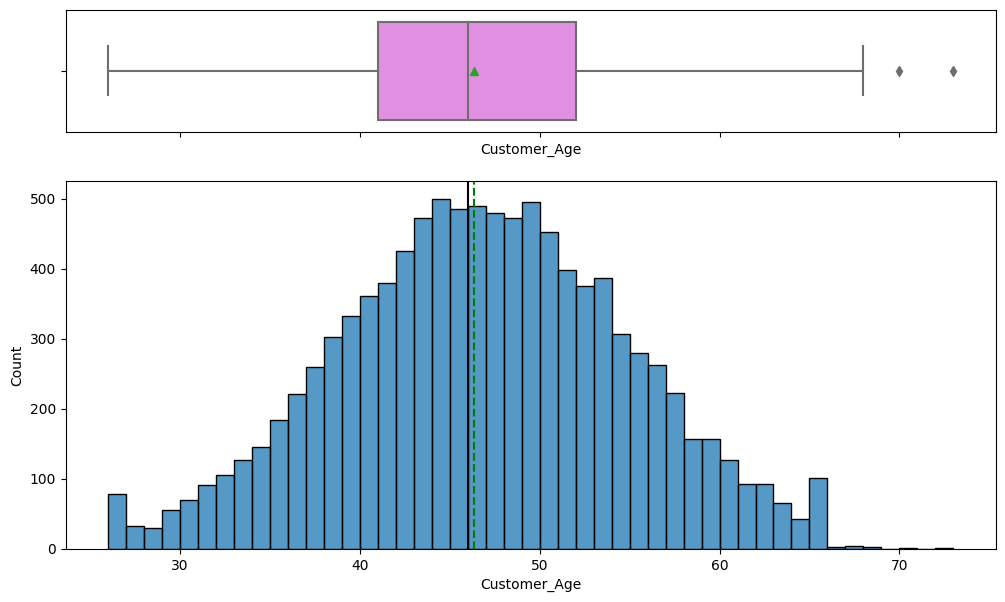

In [ ]:
#observation on age
histogram_boxplot(data,'Customer_Age')

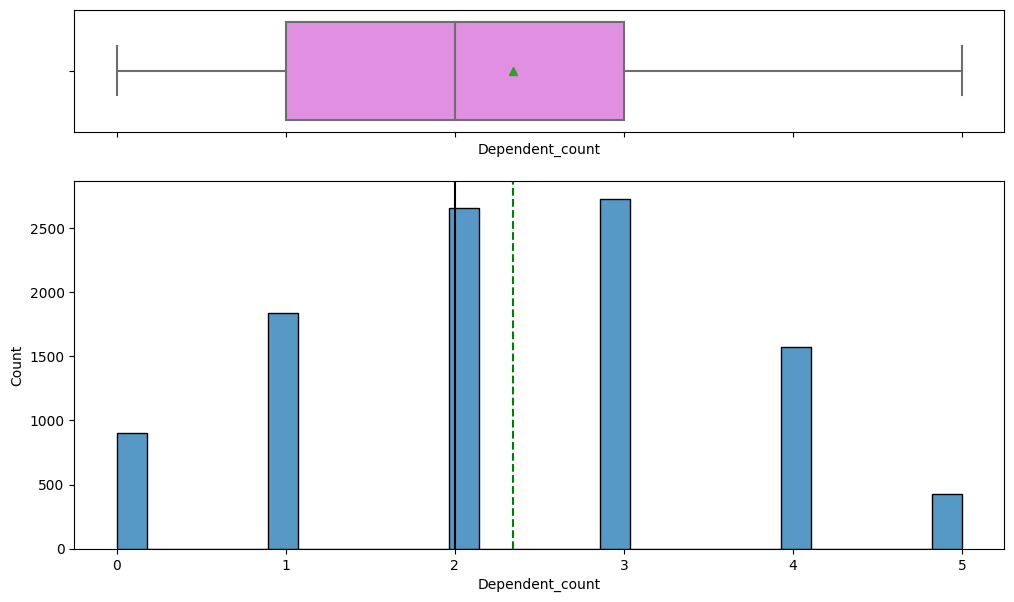

In [ ]:
#observation on dependent count
histogram_boxplot(data,'Dependent_count')

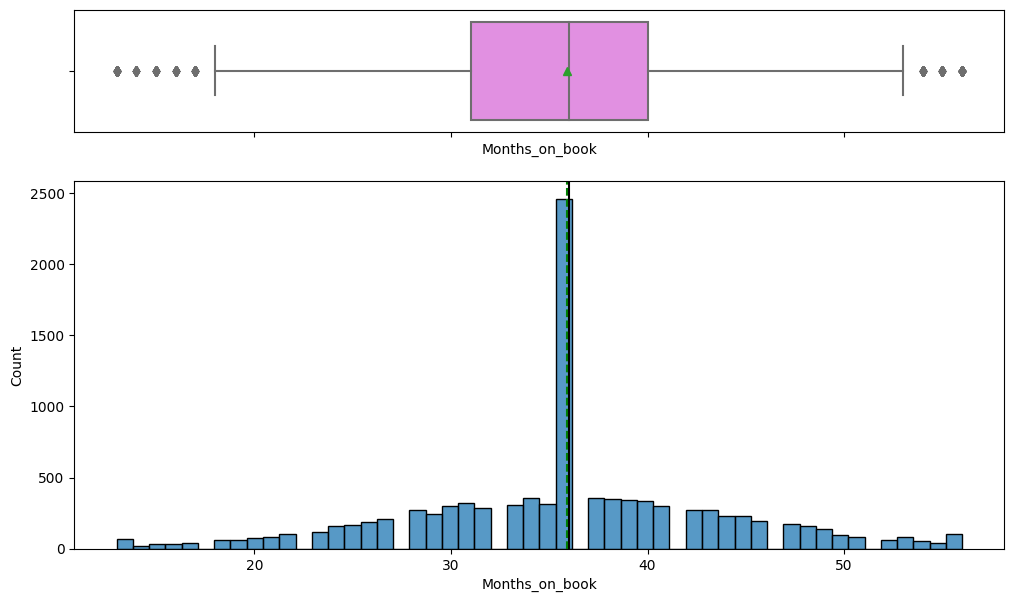

In [ ]:
#observation on Months_on_book
histogram_boxplot(data,'Months_on_book')

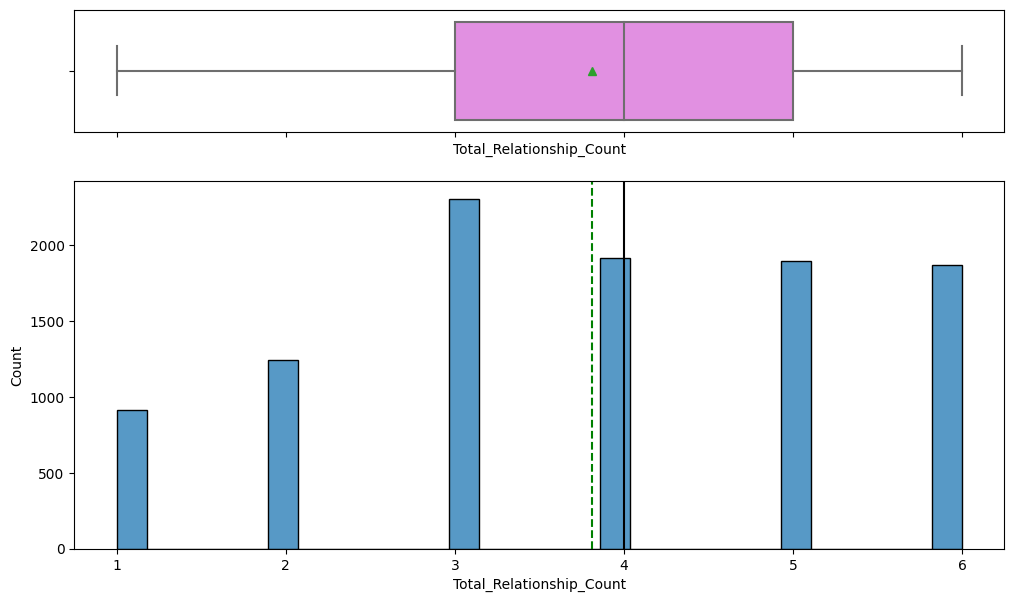

In [ ]:
#observation on Total_Relationship_Count
histogram_boxplot(data,'Total_Relationship_Count')

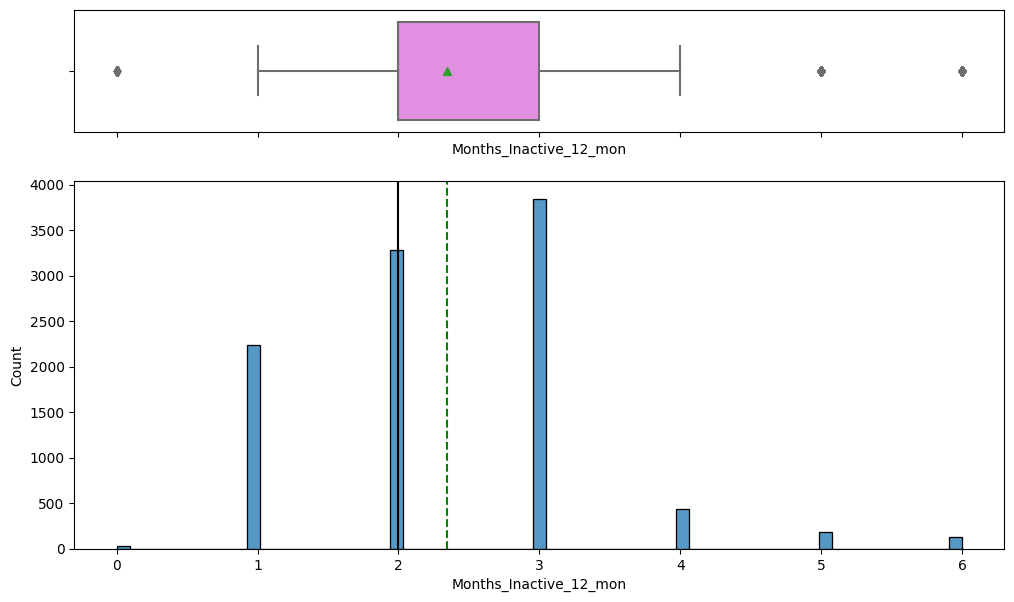

In [ ]:
#observation on Months_Inactive_12_mon
histogram_boxplot(data,'Months_Inactive_12_mon')

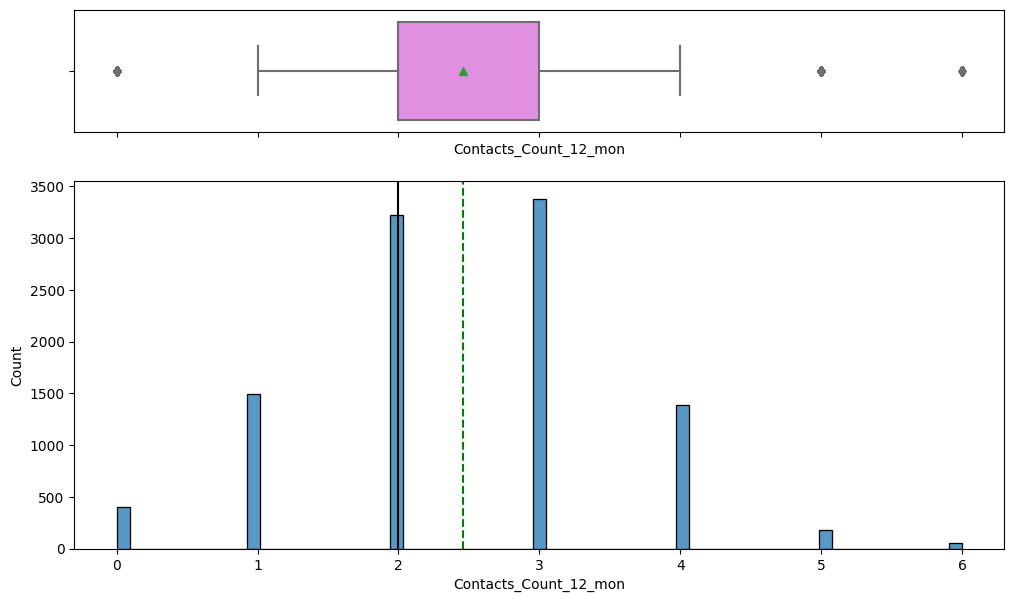

In [ ]:
#observation on Contacts_Count_12_mon
histogram_boxplot(data,'Contacts_Count_12_mon')

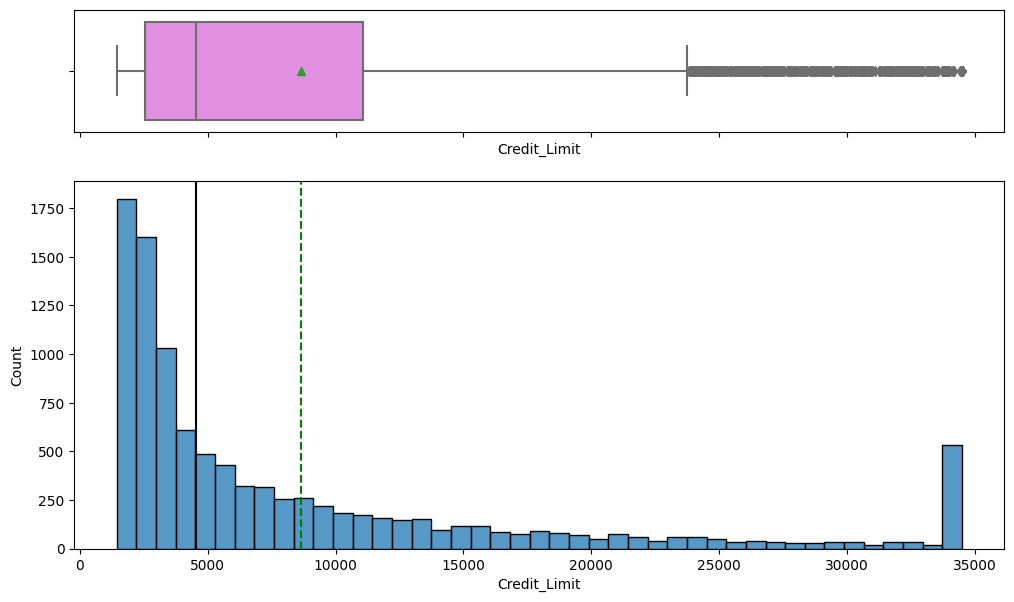

In [ ]:
#observation on Credit_Limit
histogram_boxplot(data,'Credit_Limit')

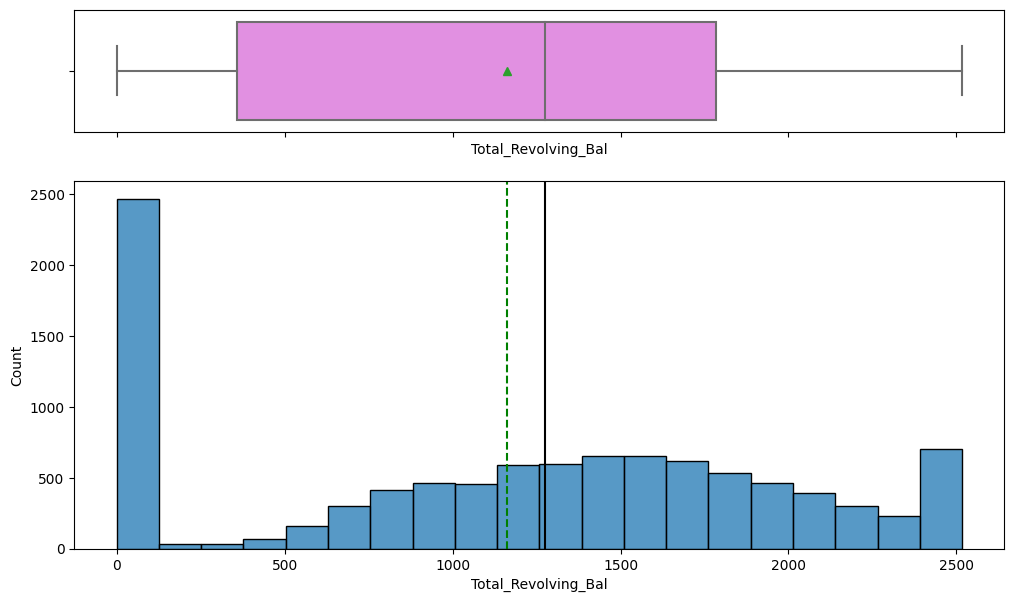

In [ ]:
#observation on Total_Revolving_Bal
histogram_boxplot(data,'Total_Revolving_Bal')

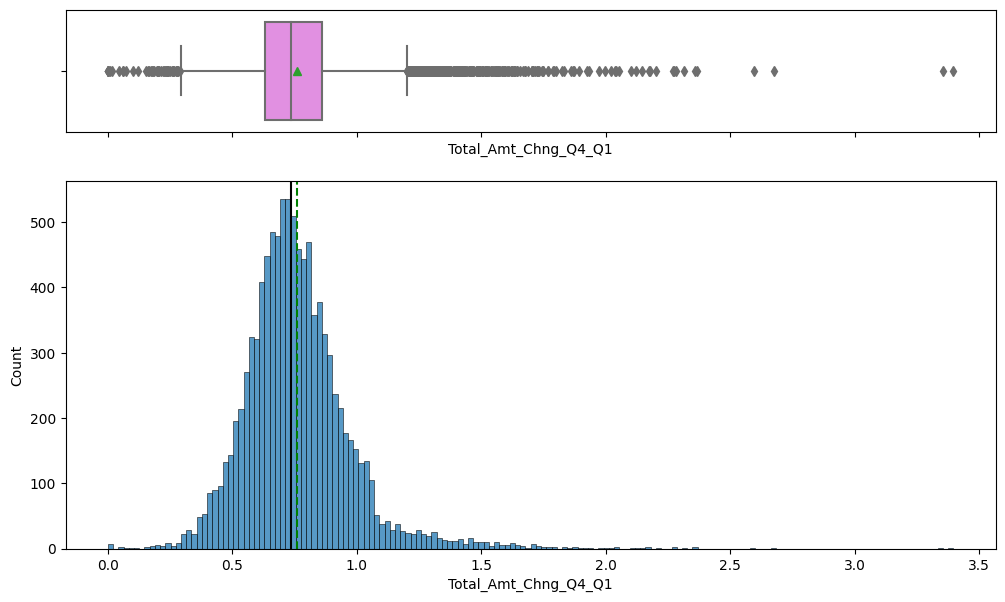

In [ ]:
#observation on Total_Amt_Chng_Q4_Q1
histogram_boxplot(data,'Total_Amt_Chng_Q4_Q1')

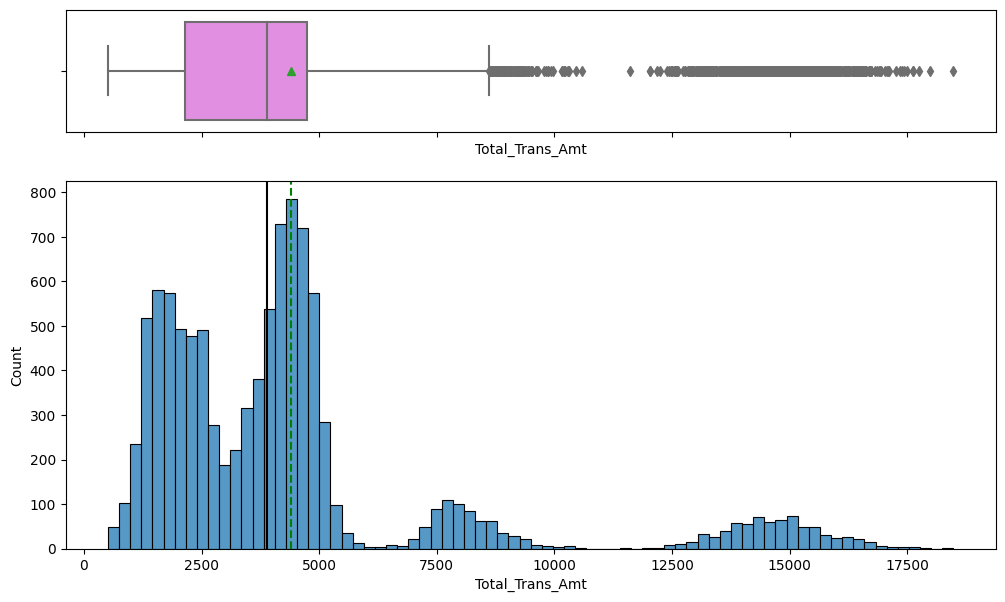

In [ ]:
#observation on Total_Trans_Amt
histogram_boxplot(data,'Total_Trans_Amt')

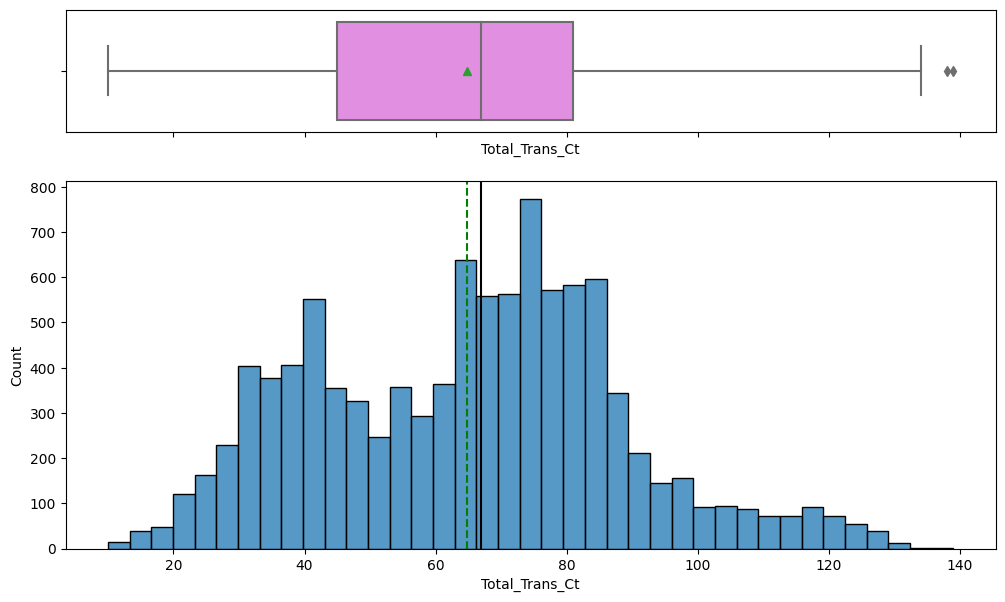

In [ ]:
#observation on Total_Trans_Ct
histogram_boxplot(data,'Total_Trans_Ct')

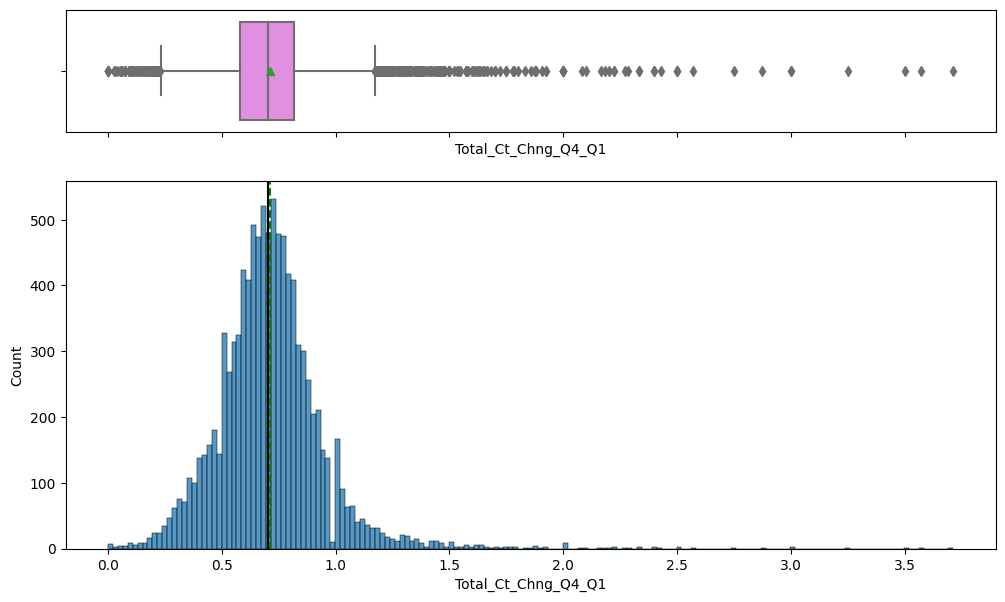

In [ ]:
#observation on Total_Ct_Chng_Q4_Q1
histogram_boxplot(data,'Total_Ct_Chng_Q4_Q1')

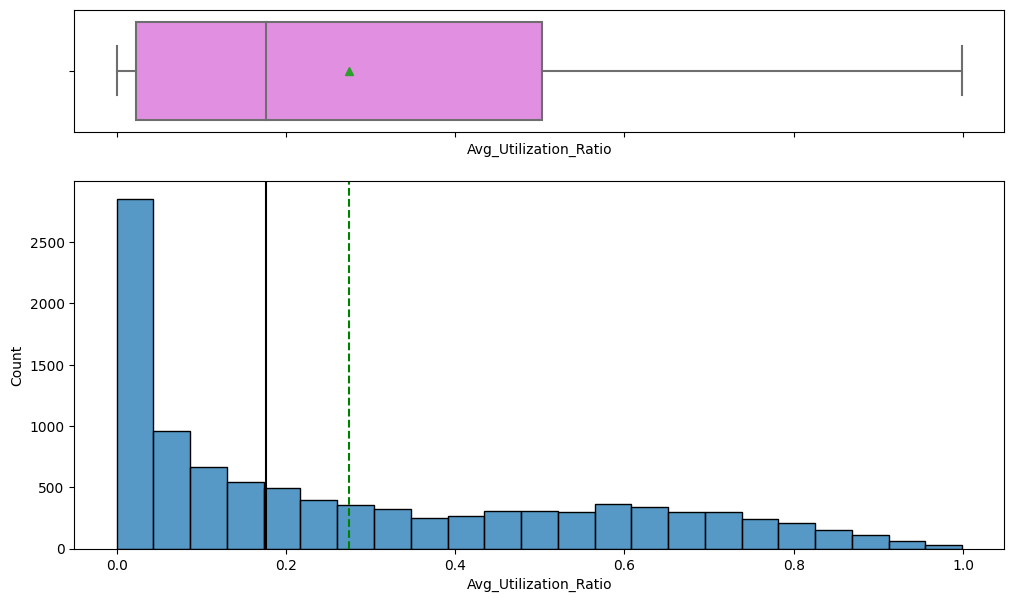

In [ ]:
#observation on Avg_Utilization_Ratio
histogram_boxplot(data,'Avg_Utilization_Ratio')

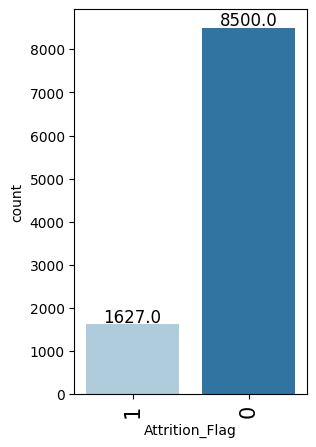

In [ ]:
#observation on Attrition_Flag
labeled_barplot(data,'Attrition_Flag')

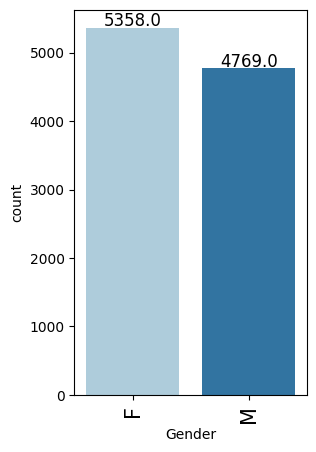

In [ ]:
#observation on Gender
labeled_barplot(data,'Gender')

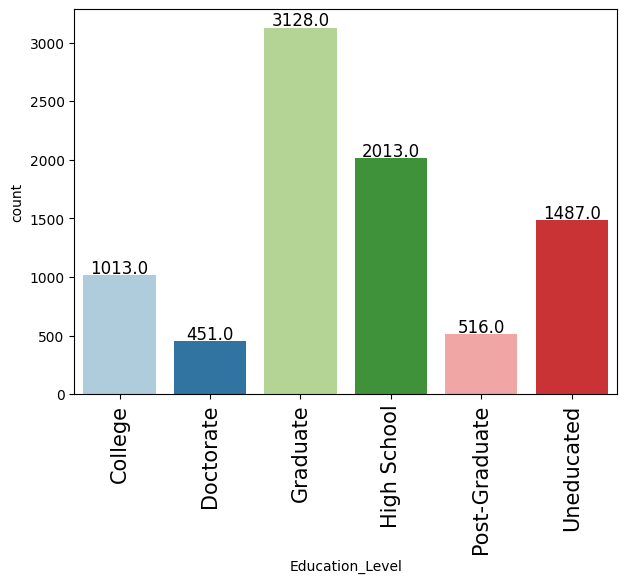

In [ ]:
#observation on Education_Level
labeled_barplot(data,'Education_Level')

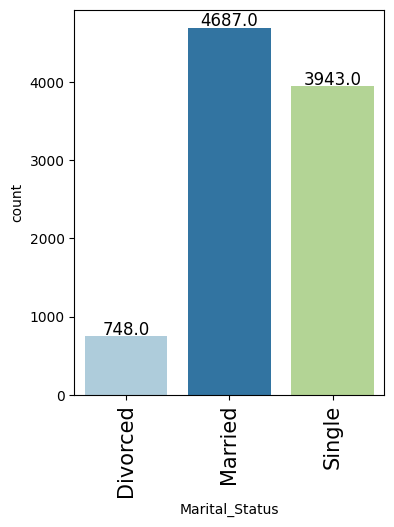

In [ ]:
#observation on Marital_Status
labeled_barplot(data,'Marital_Status')

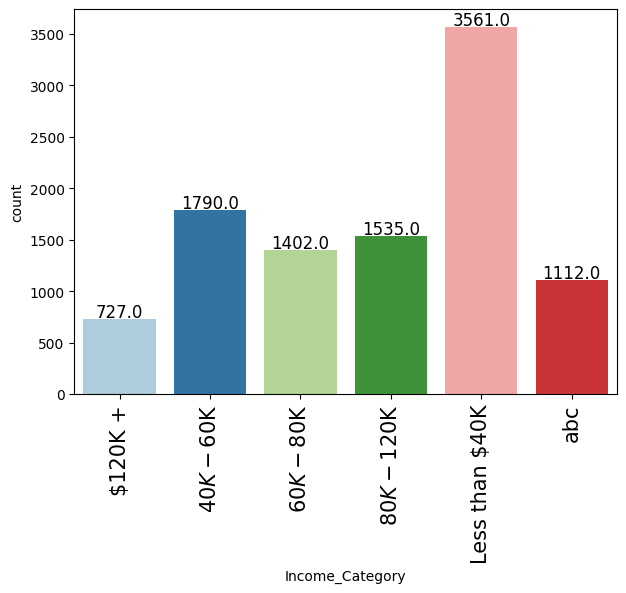

In [ ]:
#observation on Income_Category
labeled_barplot(data,'Income_Category')

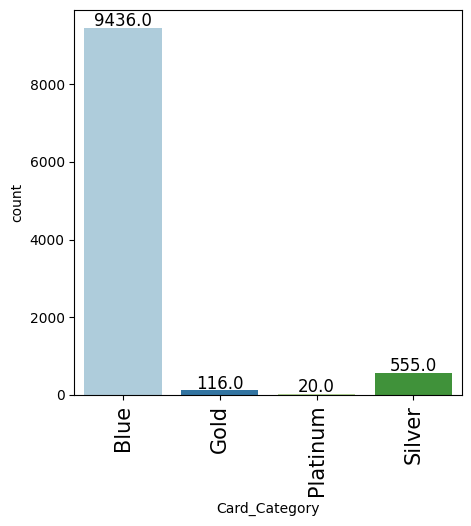

In [ ]:
#observation on Card_Category
labeled_barplot(data,'Card_Category')

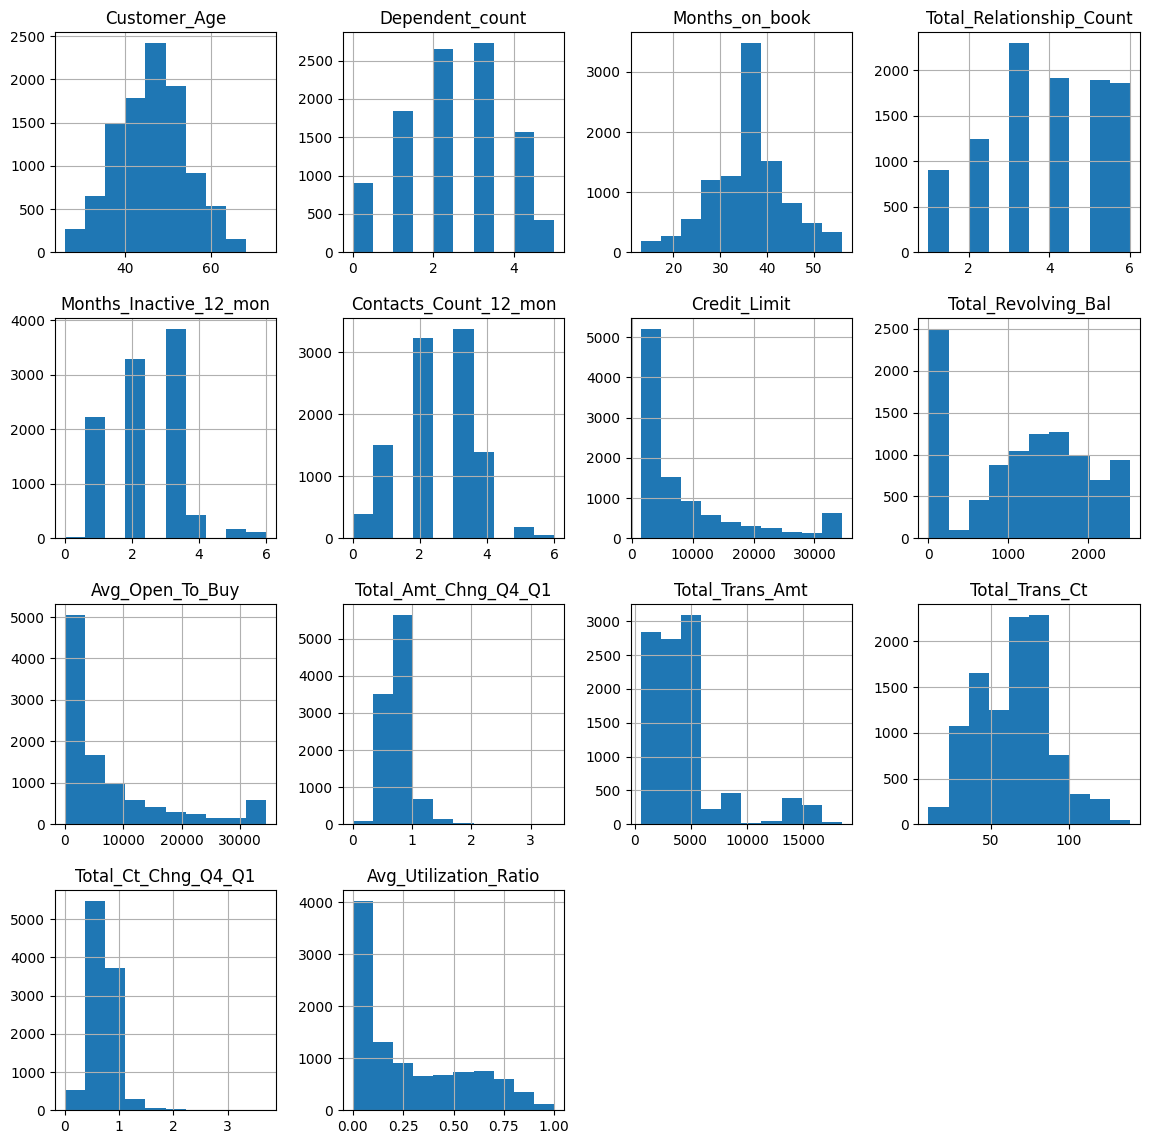

In [ ]:
data.hist(figsize=(14,14))
plt.show()

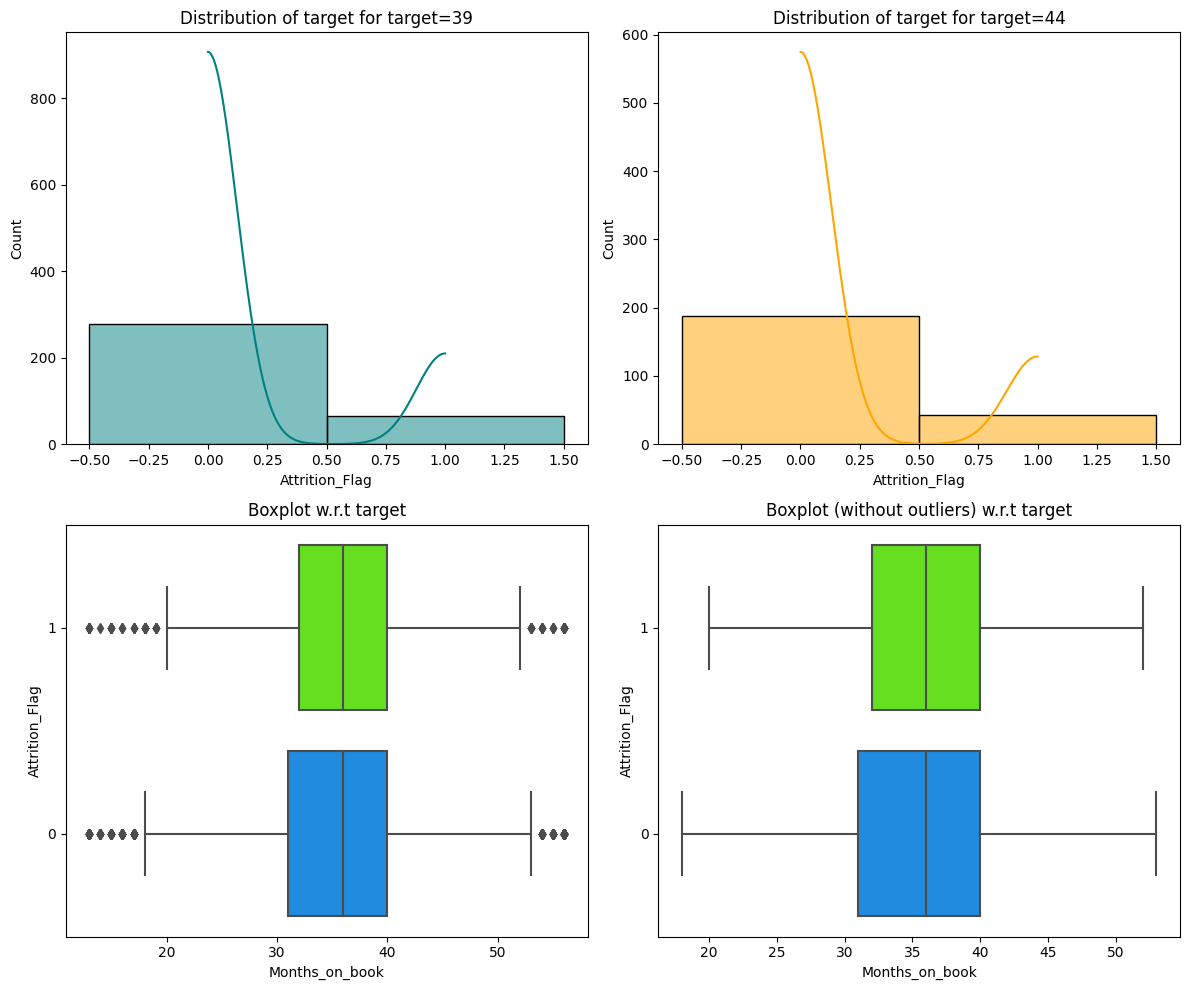

In [ ]:
distribution_plot_wrt_target(data,'Months_on_book','Attrition_Flag')

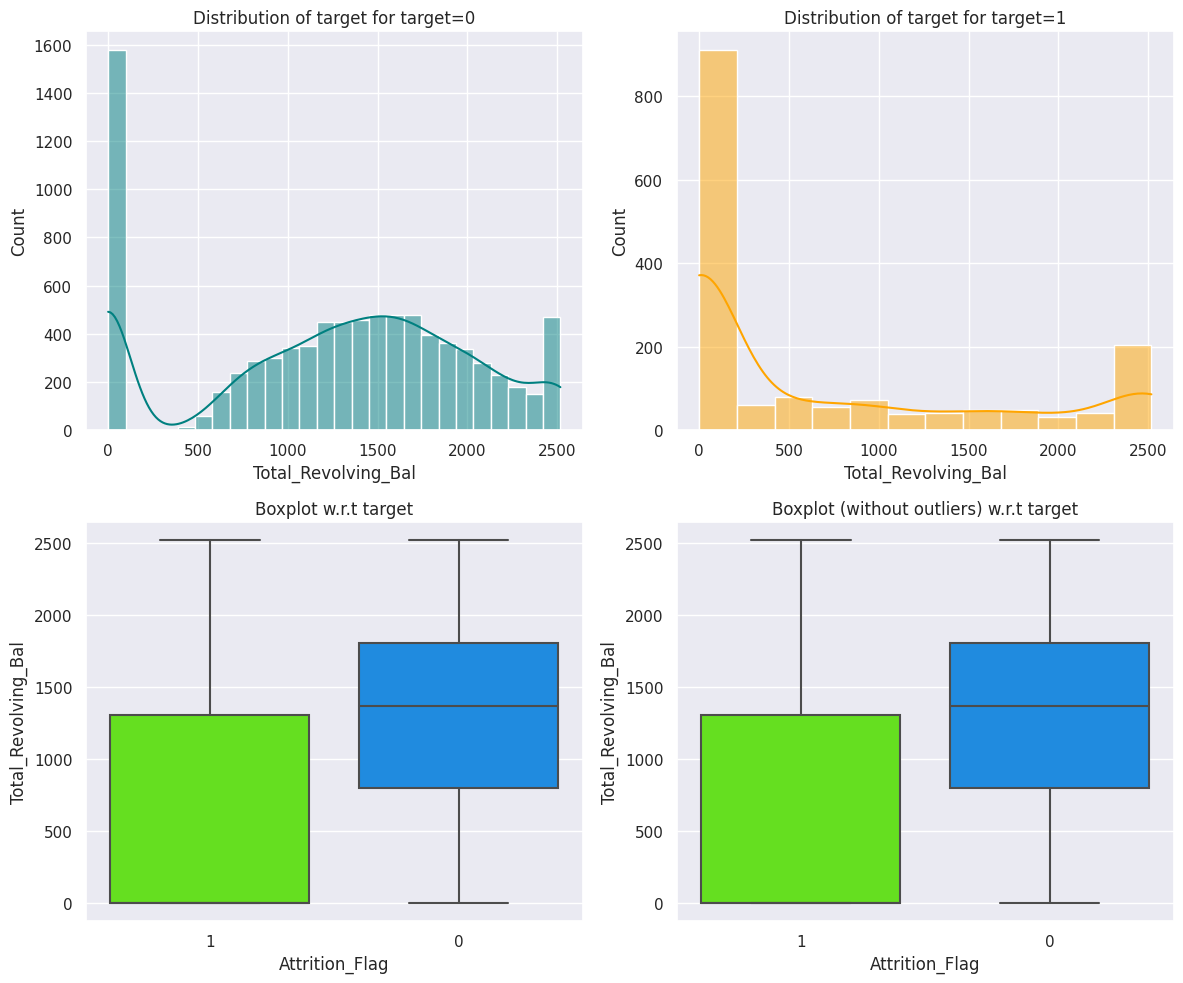

In [ ]:
distribution_plot_wrt_target(data, 'Total_Revolving_Bal','Attrition_Flag')

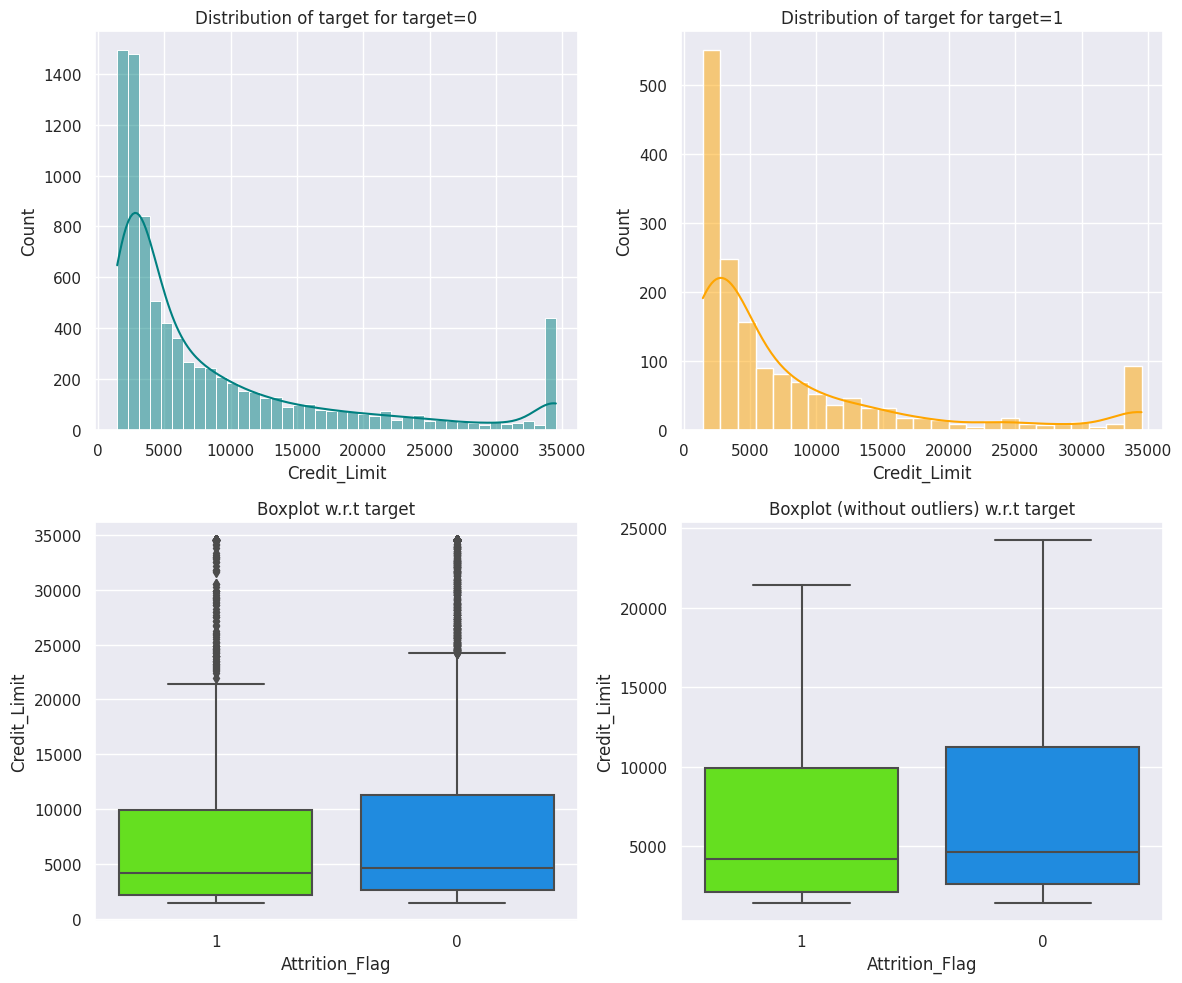

In [ ]:
distribution_plot_wrt_target(data, 'Credit_Limit','Attrition_Flag')

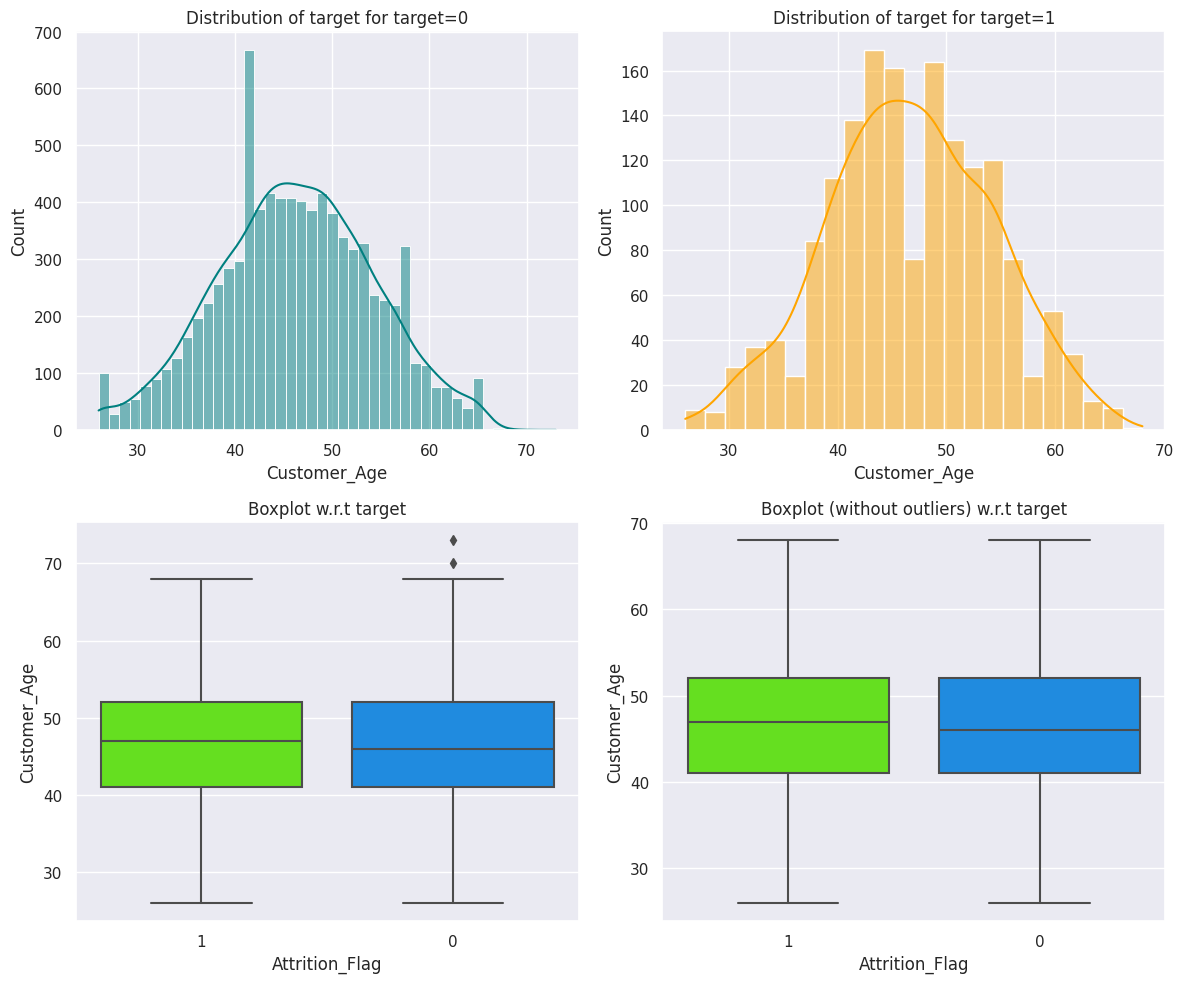

In [ ]:
distribution_plot_wrt_target(data, 'Customer_Age','Attrition_Flag')

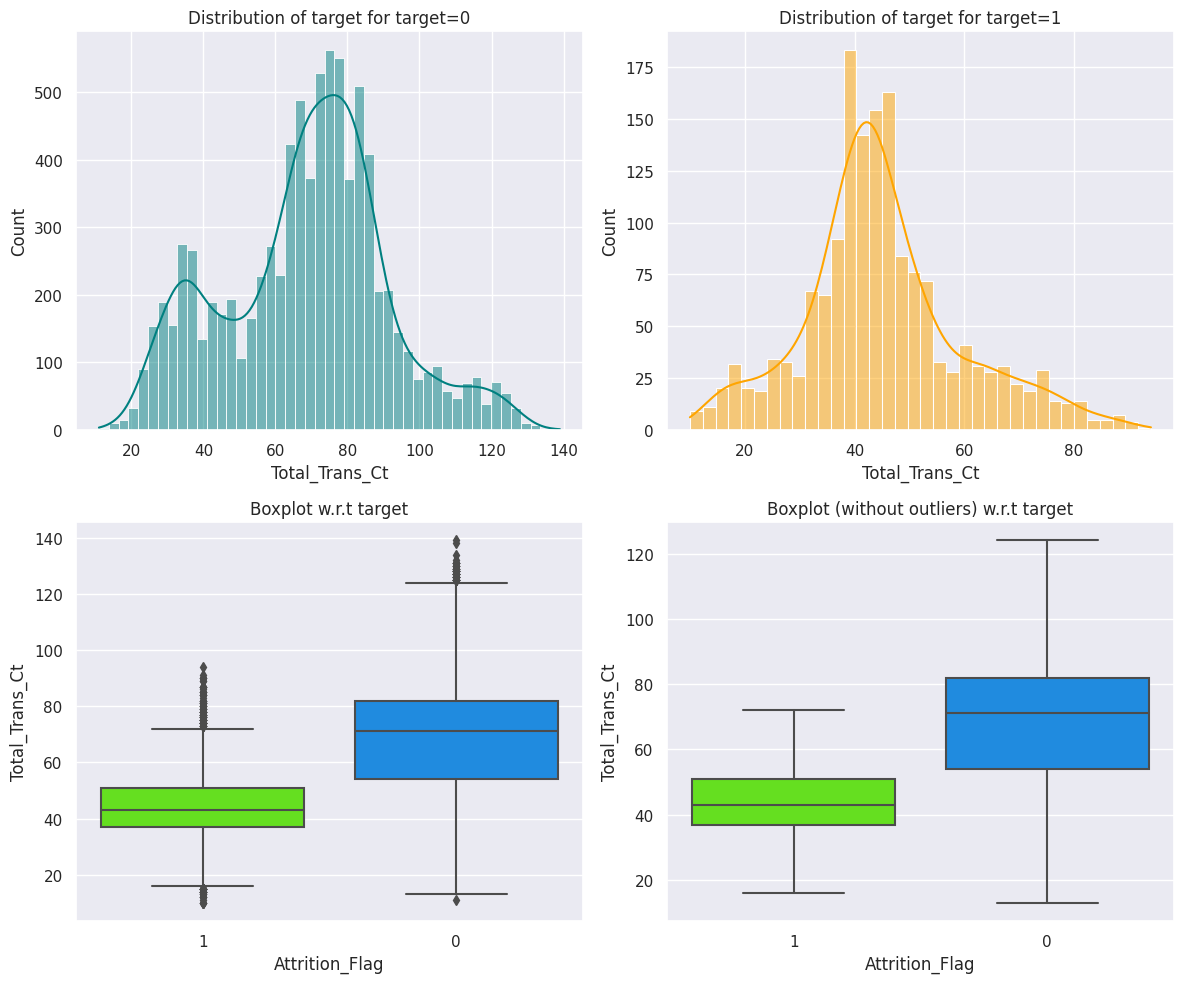

In [ ]:
distribution_plot_wrt_target(data, 'Total_Trans_Ct','Attrition_Flag')

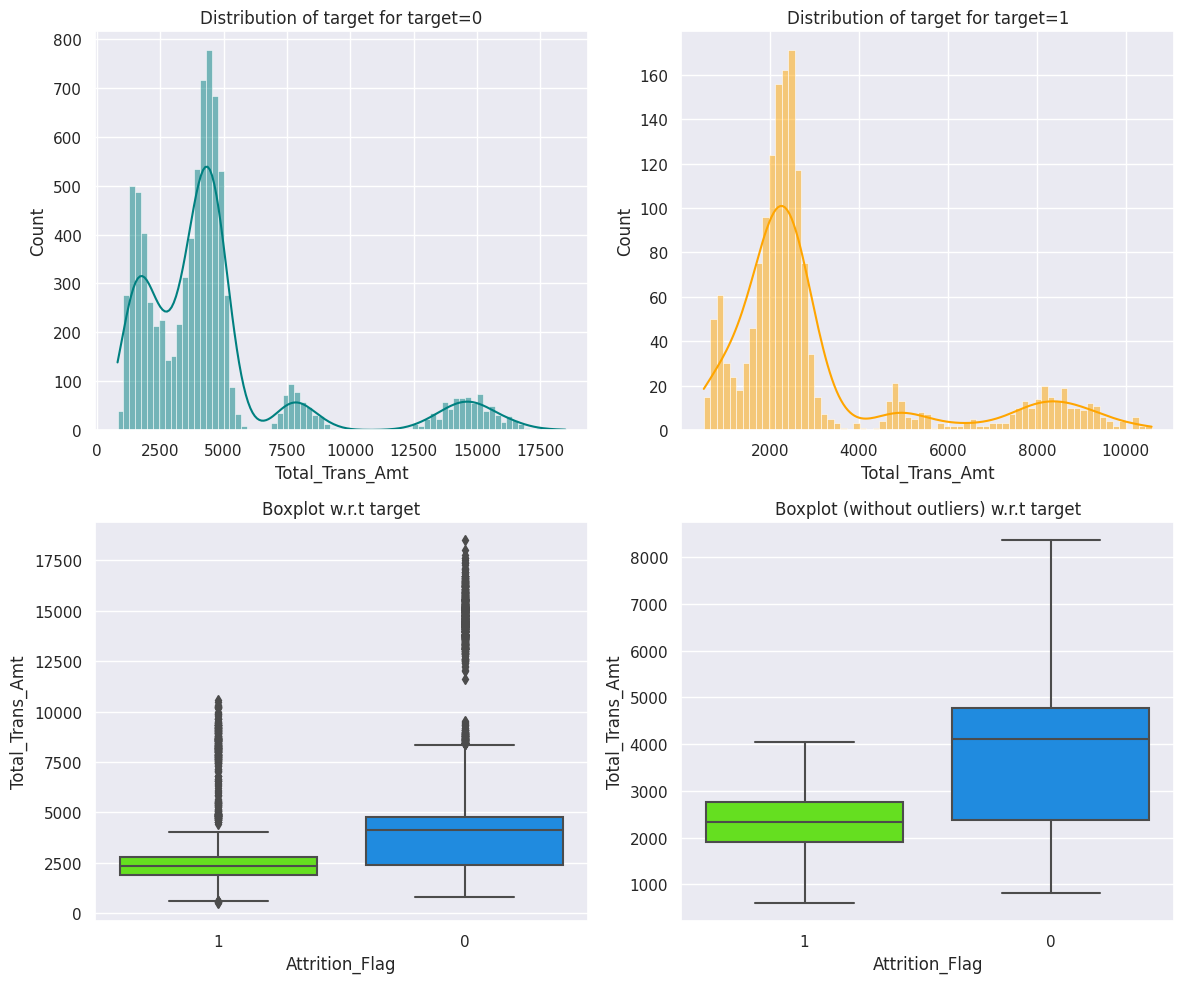

In [ ]:
distribution_plot_wrt_target(data, 'Total_Trans_Amt','Attrition_Flag')

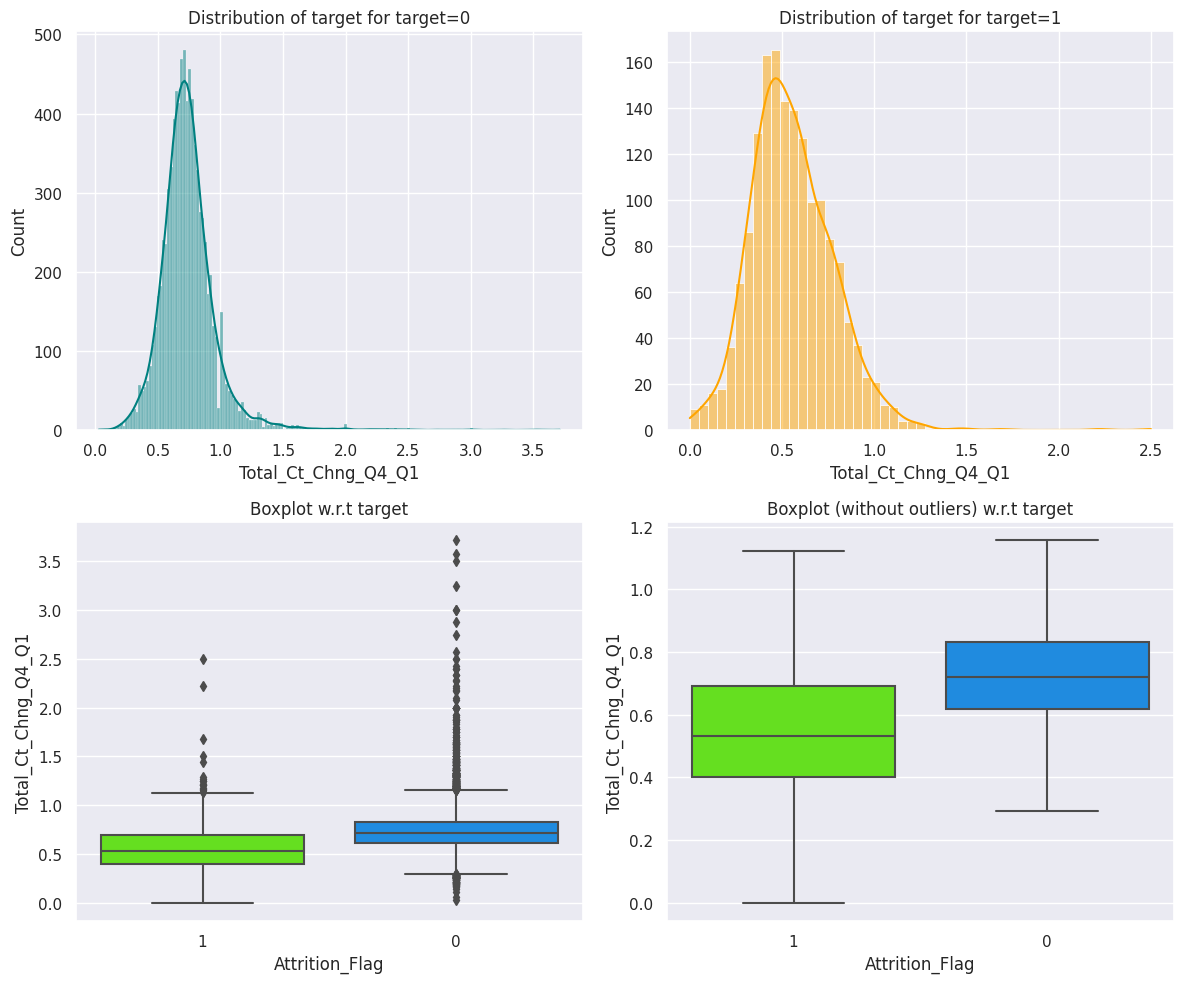

In [ ]:
distribution_plot_wrt_target(data, 'Total_Ct_Chng_Q4_Q1','Attrition_Flag')

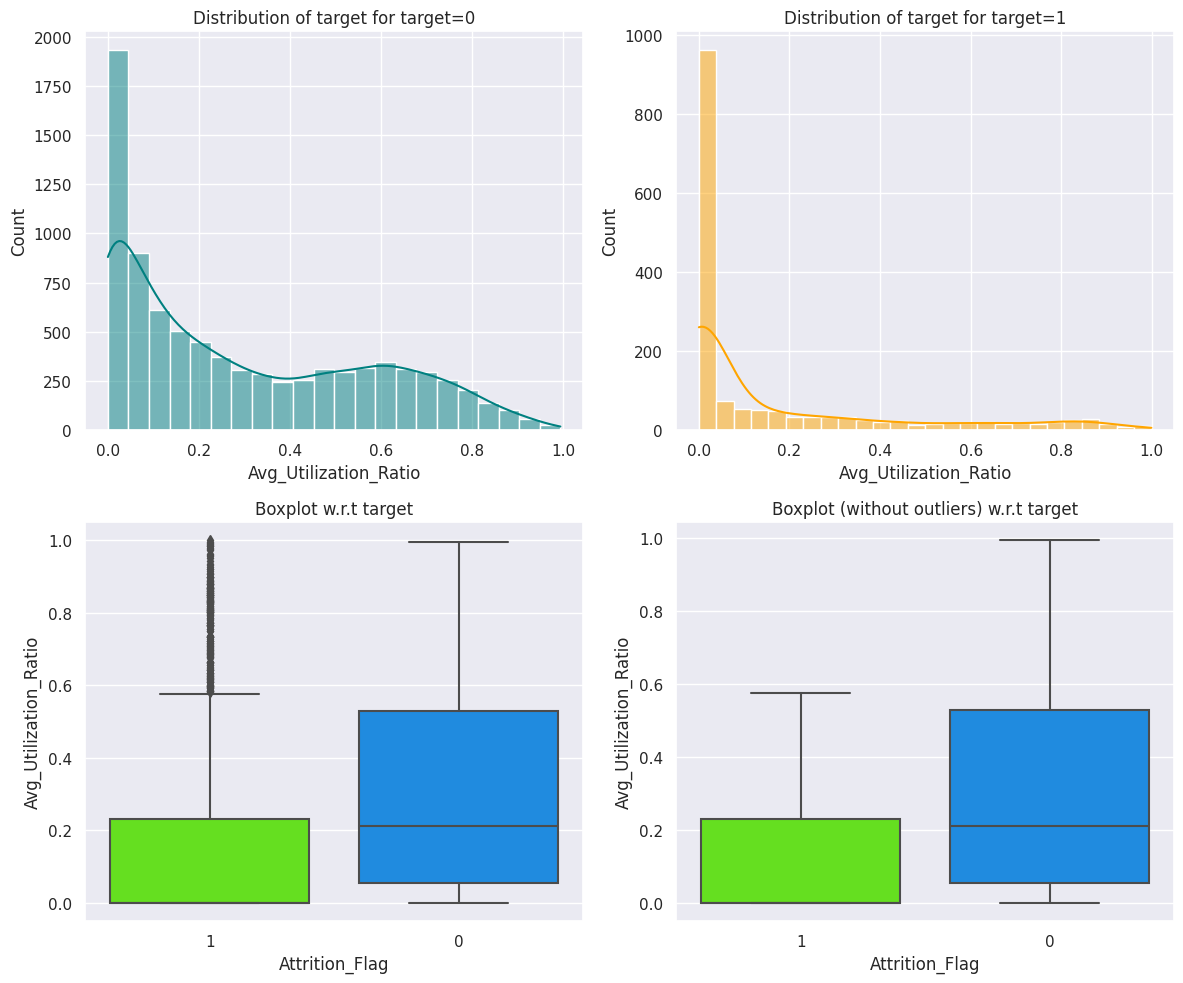

In [ ]:
distribution_plot_wrt_target(data, 'Avg_Utilization_Ratio','Attrition_Flag')

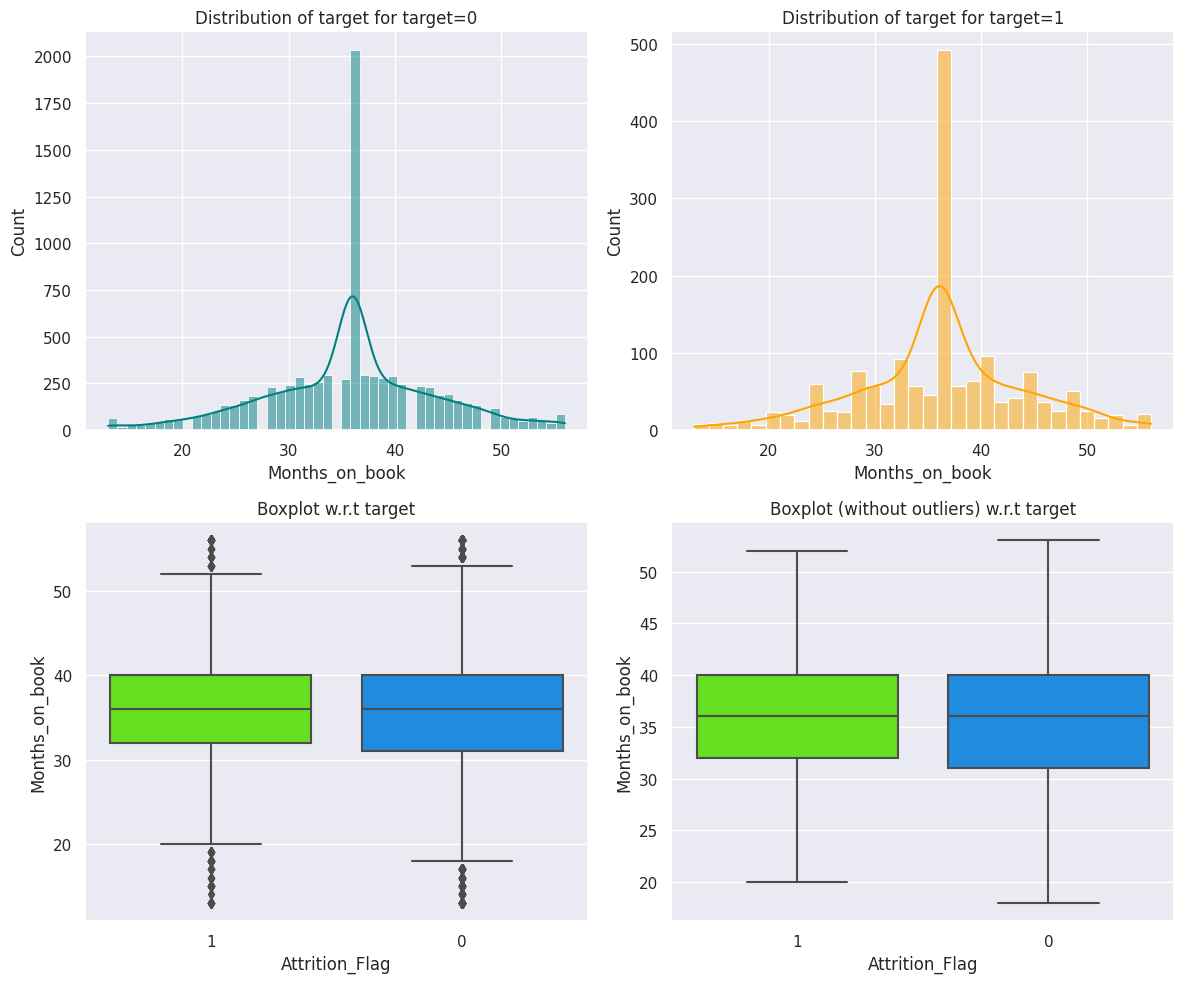

In [ ]:
distribution_plot_wrt_target(data, 'Months_on_book','Attrition_Flag')

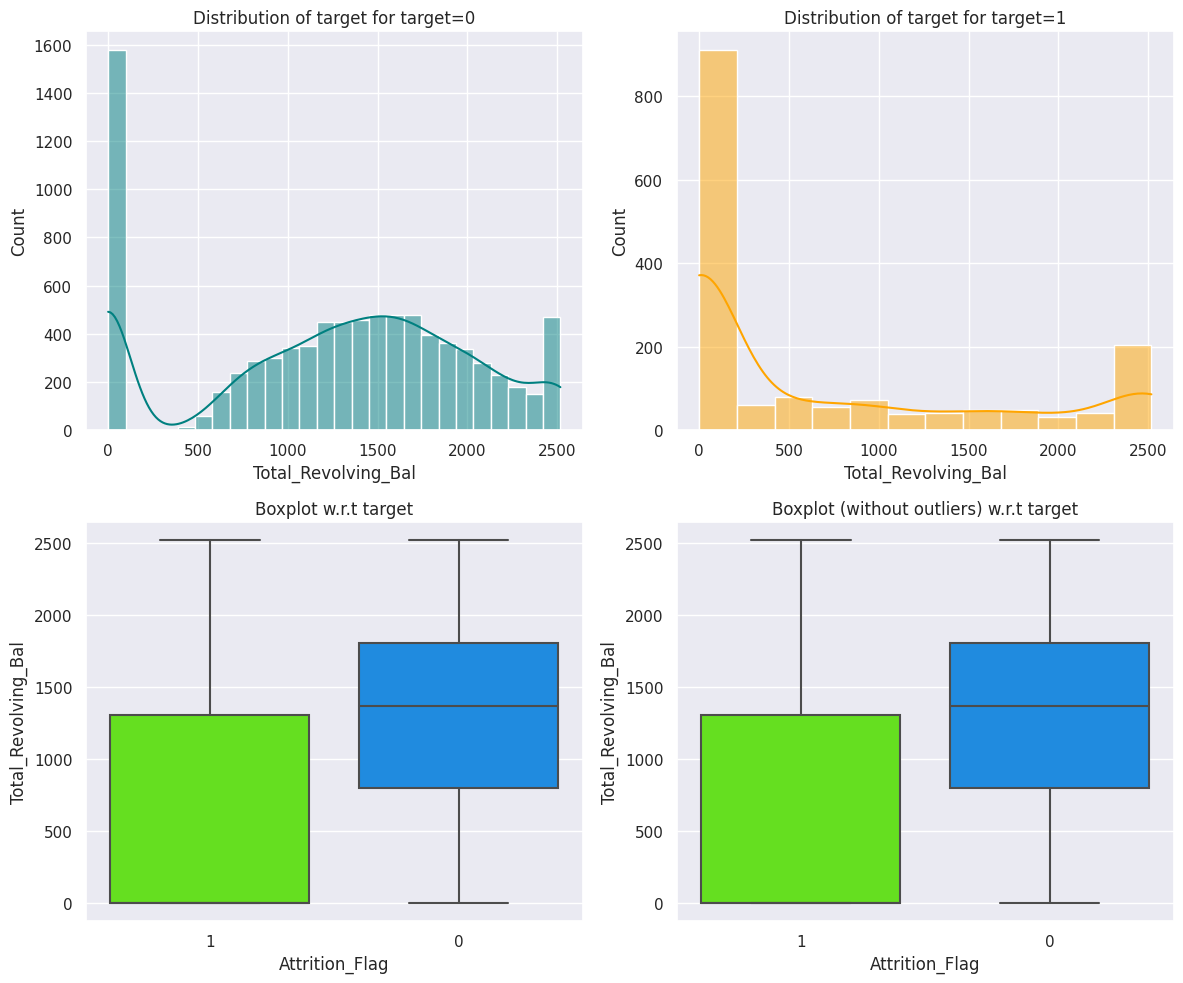

In [ ]:
distribution_plot_wrt_target(data, 'Total_Revolving_Bal','Attrition_Flag')

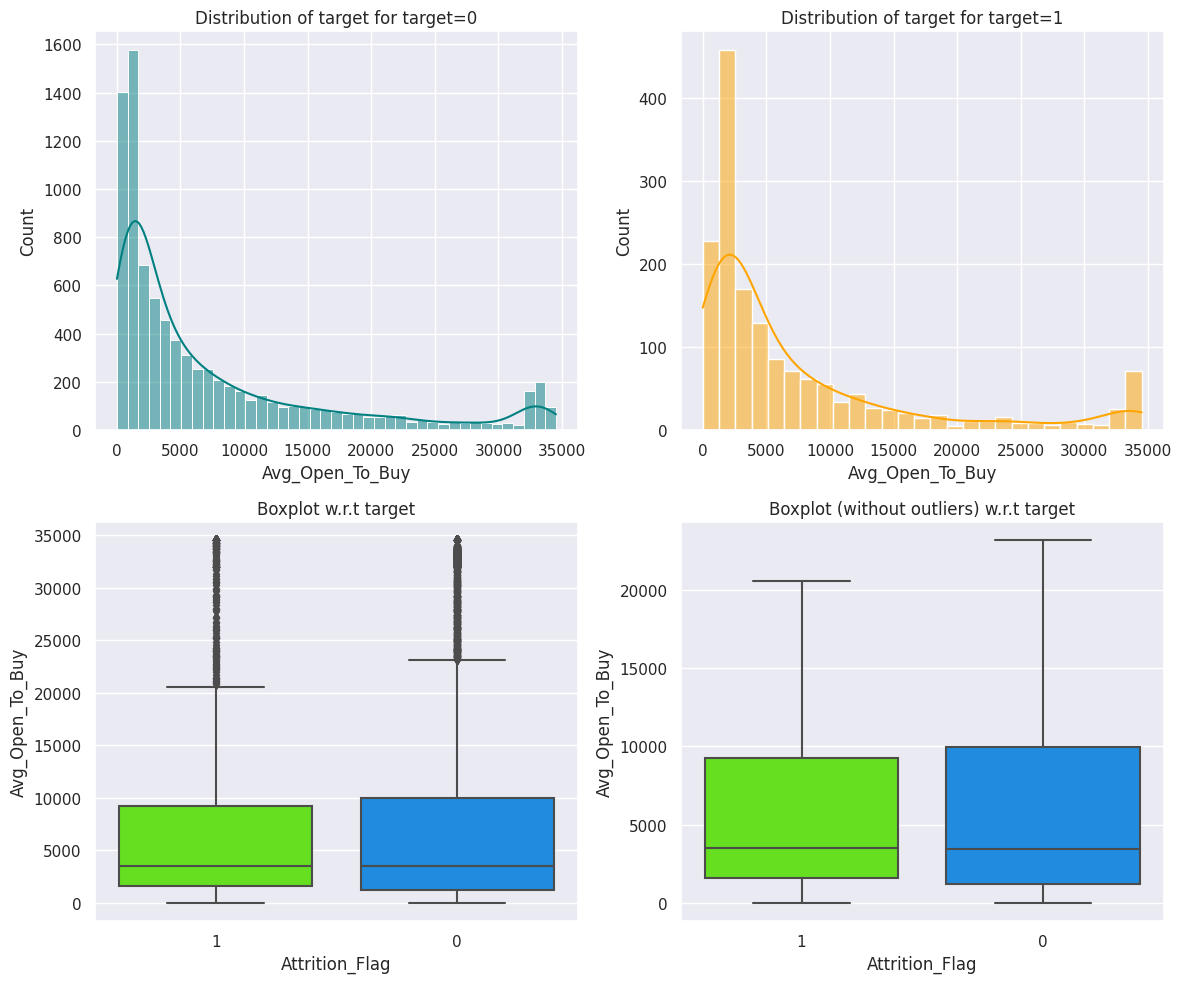

In [ ]:
distribution_plot_wrt_target(data, 'Avg_Open_To_Buy','Attrition_Flag')

In [ ]:
data.describe(include=['category']).T

,count,unique,top,freq
Attrition_Flag,10127,2,0,8500
Gender,10127,2,F,5358
Education_Level,8608,6,Graduate,3128
Marital_Status,9378,3,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


Attrition_Flag     1     0    All
Gender                           
All             1627  8500  10127
F                930  4428   5358
M                697  4072   4769
------------------------------------------------------------------------------------------------------------------------


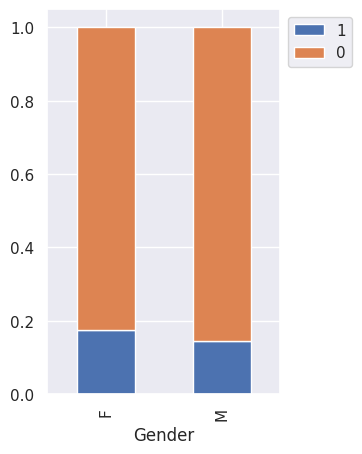

In [ ]:
stacked_barplot(data,'Gender','Attrition_Flag')

Attrition_Flag     1     0    All
Card_Category                    
All             1627  8500  10127
Blue            1519  7917   9436
Silver            82   473    555
Gold              21    95    116
Platinum           5    15     20
------------------------------------------------------------------------------------------------------------------------


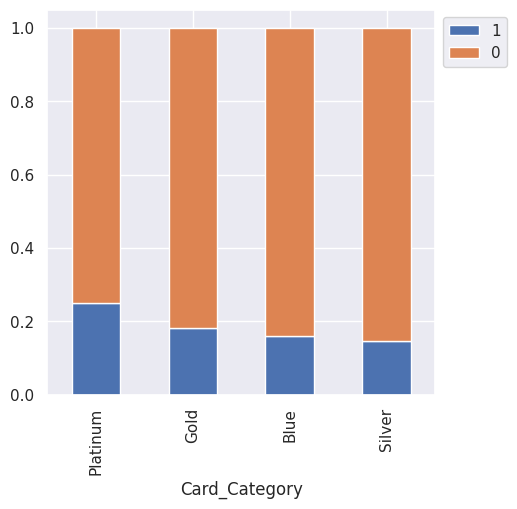

In [ ]:
stacked_barplot(data,'Card_Category','Attrition_Flag')

Attrition_Flag      1     0    All
Income_Category                   
All              1627  8500  10127
Less than $40K    612  2949   3561
$40K - $60K       271  1519   1790
$80K - $120K      242  1293   1535
$60K - $80K       189  1213   1402
abc               187   925   1112
$120K +           126   601    727
------------------------------------------------------------------------------------------------------------------------


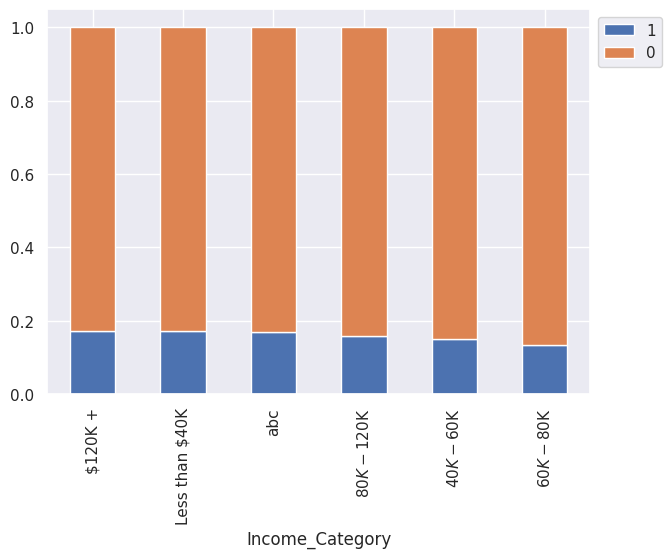

In [ ]:
stacked_barplot(data,'Income_Category','Attrition_Flag')

Attrition_Flag     1     0   All
Marital_Status                  
All             1498  7880  9378
Married          709  3978  4687
Single           668  3275  3943
Divorced         121   627   748
------------------------------------------------------------------------------------------------------------------------


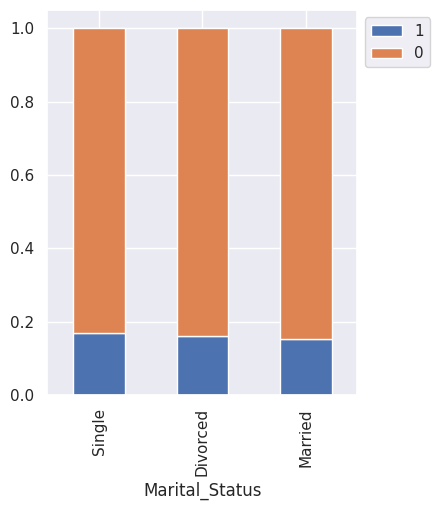

In [ ]:
stacked_barplot(data,'Marital_Status','Attrition_Flag')

Attrition_Flag      1     0   All
Education_Level                  
All              1371  7237  8608
Graduate          487  2641  3128
High School       306  1707  2013
Uneducated        237  1250  1487
College           154   859  1013
Doctorate          95   356   451
Post-Graduate      92   424   516
------------------------------------------------------------------------------------------------------------------------


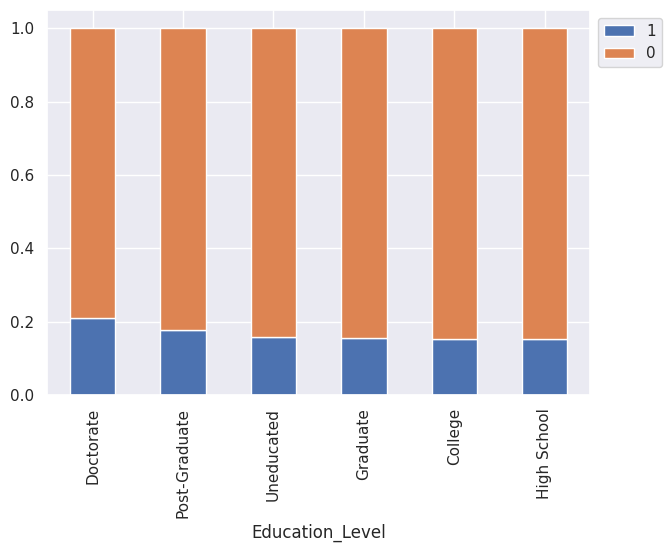

In [ ]:
stacked_barplot(data,'Education_Level','Attrition_Flag')

Attrition_Flag            1     0    All
Contacts_Count_12_mon                   
All                    1627  8500  10127
3                       681  2699   3380
2                       403  2824   3227
4                       315  1077   1392
1                       108  1391   1499
5                        59   117    176
6                        54     0     54
0                         7   392    399
------------------------------------------------------------------------------------------------------------------------


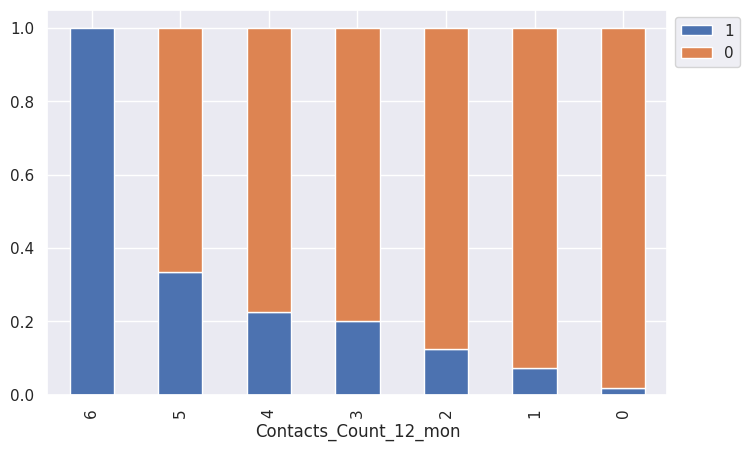

In [ ]:
stacked_barplot(data,'Contacts_Count_12_mon','Attrition_Flag')

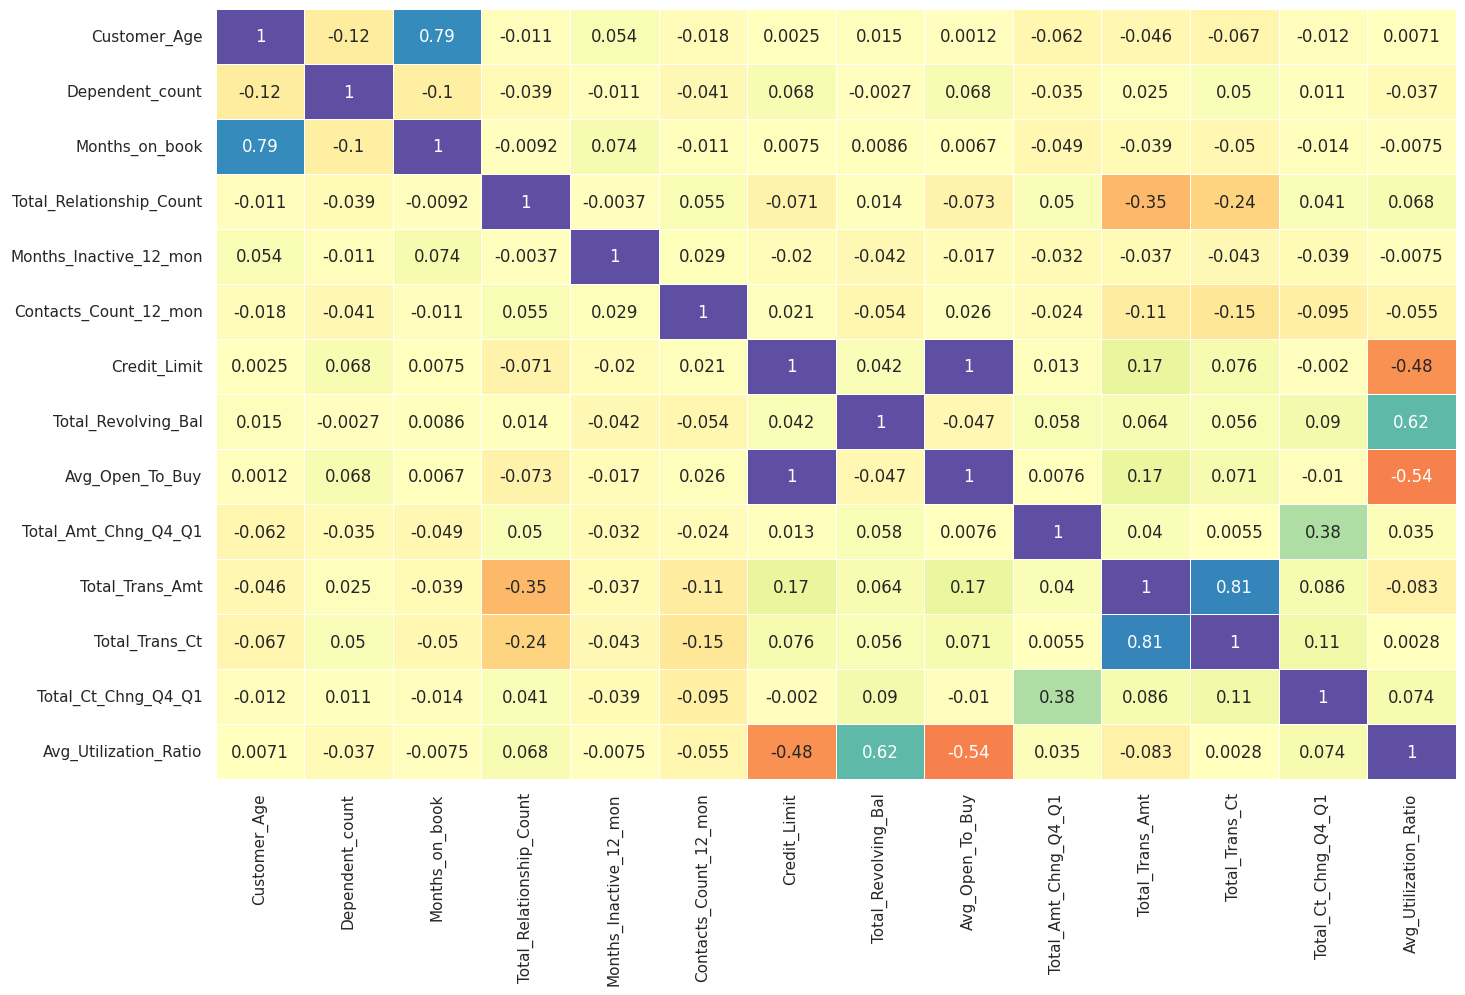

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(data.corr(),
            annot=True,
            linewidth=.5,
            center=0,
            cbar=False,
            cmap='Spectral')
plt.show()

## Data Pre-processing

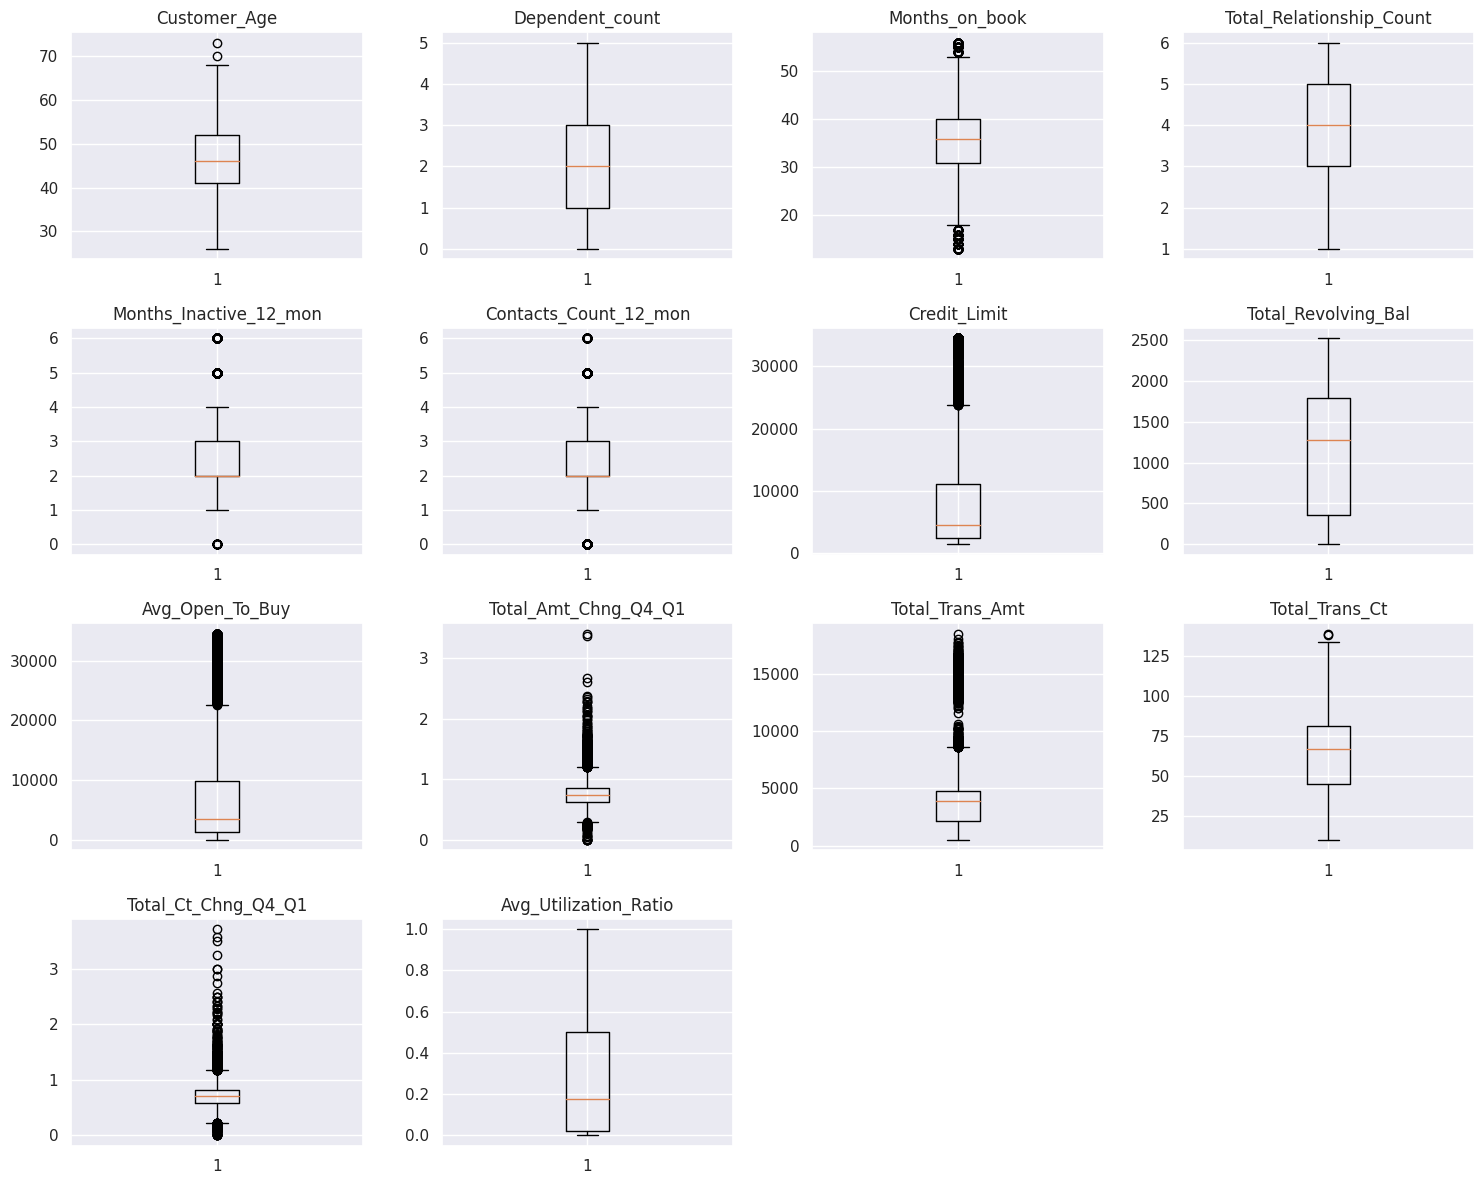

In [ ]:
#outlier detection using boxplot
numeric_columns=data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=((15,12)))

for i, variable in enumerate(numeric_columns):
  plt.subplot(4,4,i+1)
  plt.boxplot(data[variable], whis=1.5)
  plt.tight_layout()
  plt.title(variable)

plt.show()

Q1=data.quantile(0.25)
Q3=data.quantile(0.75)

IQR=Q3-Q1
lower=(Q1-1.5*IQR)
upper=(Q3+1.5*IQR)

- will not treat them if thet are proper values

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           8608 non-null   category
 5   Marital_Status            9378 non-null   category
 6   Income_Category           10127 non-null  category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

In [ ]:
((data.select_dtypes(include=['float64','int64'])<lower)|(data.select_dtypes(include=['float64','int64'])>upper)).sum()

Customer_Age                  2
Dependent_count               0
Months_on_book              386
Total_Relationship_Count      0
Months_Inactive_12_mon      331
Contacts_Count_12_mon       629
Credit_Limit                984
Total_Revolving_Bal           0
Avg_Open_To_Buy             963
Total_Amt_Chng_Q4_Q1        396
Total_Trans_Amt             896
Total_Trans_Ct                2
Total_Ct_Chng_Q4_Q1         394
Avg_Utilization_Ratio         0
dtype: int64

In [ ]:
#train test data split
data1=data.copy()

In [ ]:
data1['Income_Category'].replace('abc',np.nan,inplace=True)

In [ ]:
data1['Income_Category'].value_counts(dropna=False)

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
NaN               1112
$120K +            727
Name: Income_Category, dtype: int64

In [ ]:
data1.isna().sum()

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [ ]:
#replace the na with: mean/median/most frequent/etc
impute=SimpleImputer(strategy='most_frequent')

In [ ]:
data1.isna().sum()

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [ ]:
data1['Income_Category'].value_counts(dropna=False)

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
NaN               1112
$120K +            727
Name: Income_Category, dtype: int64

In [ ]:
X=data1.drop(['Attrition_Flag'],axis=1)
y=data1['Attrition_Flag']

#creating dummy variables
#drop_first=True: prevent multocolinary
X=pd.get_dummies(X, drop_first=True)

## Missing value imputation




In [ ]:
#random_state=1, stratify=y, shuffle=True
#spliting into training, validation, and testing sets

#first: split data into 2 parts - temp and test
X_temp, X_test, y_temp, y_test=train_test_split(X, y , test_size=0.2, random_state=1, stratify=y)
#secondly: split the temp into 2 parts - train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp,test_size=0.25, random_state=1, stratify=y_temp)

print(X_train.shape, X_test.shape, X_val.shape)

(6075, 29) (2026, 29) (2026, 29)


- be aware: if the data is in chronological order. If so the train test split will have problem when not shuffle.
  - solution: **shuffle=True**

In [ ]:
y.value_counts(1)

0   0.839
1   0.161
Name: Attrition_Flag, dtype: float64

In [ ]:
y_test.value_counts(1)
#this rate of 83.9% and 16% will later be used in reversed (17% and 83%) in decisiontreeclassifier on the class_weight

0   0.840
1   0.160
Name: Attrition_Flag, dtype: float64

In [ ]:
X_test.dtypes

Customer_Age                        int64
Dependent_count                     int64
Months_on_book                      int64
Total_Relationship_Count            int64
Months_Inactive_12_mon              int64
Contacts_Count_12_mon               int64
Credit_Limit                      float64
Total_Revolving_Bal                 int64
Avg_Open_To_Buy                   float64
Total_Amt_Chng_Q4_Q1              float64
Total_Trans_Amt                     int64
Total_Trans_Ct                      int64
Total_Ct_Chng_Q4_Q1               float64
Avg_Utilization_Ratio             float64
Gender_M                            uint8
Education_Level_Doctorate           uint8
Education_Level_Graduate            uint8
Education_Level_High School         uint8
Education_Level_Post-Graduate       uint8
Education_Level_Uneducated          uint8
Marital_Status_Married              uint8
Marital_Status_Single               uint8
Income_Category_$40K - $60K         uint8
Income_Category_$60K - $80K       

- imbalance dataset --> solve
- if not giving enough sample to training, will not be good in predicting

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           8608 non-null   category
 5   Marital_Status            9378 non-null   category
 6   Income_Category           10127 non-null  category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

In [ ]:
#cat_cols=list(X_train.select_dtypes(include=['object','category']).columns)
num_cols=list(X_train.select_dtypes(include=['int','float']).columns)

#Impute categorical columns
#fit_transform: making the decision of what are the values to be impute. we do not want to cause data leakage in test and validation data, only letting the train data in deciding.
#then, use the decided imputed values in training sets to impute (transform) test and validation data
#cat_imputer=SimpleImputer(strategy='most_frequent')
#X_train[cat_cols]=cat_imputer.fit_transform(X_train[cat_cols])
#X_val[cat_cols]=cat_imputer.transform(X_val[cat_cols])
#X_test[cat_cols]=cat_imputer.transform(X_test[cat_cols])

#impute numerical columns
num_imputer=SimpleImputer(strategy='mean')
X_train[num_cols]=num_imputer.fit_transform(X_train[num_cols])
X_val[num_cols]=num_imputer.transform(X_val[num_cols])
X_test[num_cols]=num_imputer.transform(X_test[num_cols])

In [ ]:
#check that no columns has missing values in train, validation or test sets
print(X_train.isna().sum())
print('*'*50)
print(X_val.isna().sum())
print('*'*50)
print(X_test.isna().sum())
print('*'*50)

Customer_Age                      0
Dependent_count                   0
Months_on_book                    0
Total_Relationship_Count          0
Months_Inactive_12_mon            0
Contacts_Count_12_mon             0
Credit_Limit                      0
Total_Revolving_Bal               0
Avg_Open_To_Buy                   0
Total_Amt_Chng_Q4_Q1              0
Total_Trans_Amt                   0
Total_Trans_Ct                    0
Total_Ct_Chng_Q4_Q1               0
Avg_Utilization_Ratio             0
Gender_M                          0
Education_Level_Doctorate         0
Education_Level_Graduate          0
Education_Level_High School       0
Education_Level_Post-Graduate     0
Education_Level_Uneducated        0
Marital_Status_Married            0
Marital_Status_Single             0
Income_Category_$40K - $60K       0
Income_Category_$60K - $80K       0
Income_Category_$80K - $120K      0
Income_Category_Less than $40K    0
Card_Category_Gold                0
Card_Category_Platinum      

In [ ]:
#reverse mapping for encoded variables (previously to cat, new back to num)
#function to inverse the encoding
def inverse_mapping(x,y):
  inv_dict={v:k for k, v in x.items()}
  X_train[y]=np.round(X_train[y]).map(inv_dict).astype('category')
  X_val[y]=np.round(X_val[y]).map(inv_dict).astype('category')
  X_test[y]=np.round(X_test[y]).map(inv_dict).astype('category')

In [ ]:
#reqd_col_for_impute=['Education_Level','Marital_Status','Income_Category']

In [ ]:
data1['Income_Category'].value_counts(dropna=False)

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
NaN               1112
$120K +            727
Name: Income_Category, dtype: int64

In [ ]:
data1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Attrition_Flag,10127.000,2.000,0.000,8500.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_Age,10127.000,NaN,NaN,NaN,46.326,8.017,26.000,41.000,46.000,52.000,73.000
Gender,10127,2,F,5358,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependent_count,10127.000,NaN,NaN,NaN,2.346,1.299,0.000,1.000,2.000,3.000,5.000
Education_Level,8608,6,Graduate,3128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,9378,3,Married,4687,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income_Category,9015,5,Less than $40K,3561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Card_Category,10127,4,Blue,9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Months_on_book,10127.000,NaN,NaN,NaN,35.928,7.986,13.000,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.000,NaN,NaN,NaN,3.813,1.554,1.000,3.000,4.000,5.000,6.000


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           8608 non-null   category
 5   Marital_Status            9378 non-null   category
 6   Income_Category           9015 non-null   category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

In [ ]:
#imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#X_train['reqd_col_for_impute']=imputer.fit_transform(X_train[reqd_col_for_impute])

#X_val['reqd_col_for_impute']=imputer.fit_transform(X_val[reqd_col_for_impute])

#X_test['reqd_col_for_impute']=imputer.fit_transform(X_test[reqd_col_for_impute])

In [ ]:
#check if there are any missing values in train or test sets
print(X_train.isna().sum())
print('*'*50)
print(X_test.isna().sum())
print('*'*50)
print(X_val.isna().sum())

Customer_Age                      0
Dependent_count                   0
Months_on_book                    0
Total_Relationship_Count          0
Months_Inactive_12_mon            0
Contacts_Count_12_mon             0
Credit_Limit                      0
Total_Revolving_Bal               0
Avg_Open_To_Buy                   0
Total_Amt_Chng_Q4_Q1              0
Total_Trans_Amt                   0
Total_Trans_Ct                    0
Total_Ct_Chng_Q4_Q1               0
Avg_Utilization_Ratio             0
Gender_M                          0
Education_Level_Doctorate         0
Education_Level_Graduate          0
Education_Level_High School       0
Education_Level_Post-Graduate     0
Education_Level_Uneducated        0
Marital_Status_Married            0
Marital_Status_Single             0
Income_Category_$40K - $60K       0
Income_Category_$60K - $80K       0
Income_Category_$80K - $120K      0
Income_Category_Less than $40K    0
Card_Category_Gold                0
Card_Category_Platinum      

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           8608 non-null   category
 5   Marital_Status            9378 non-null   category
 6   Income_Category           9015 non-null   category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

In [ ]:
cols=X_train.select_dtypes(include=['object','category'])
for i in cols.columns:
  print(X_train[i].value_counts())
  print('*'*50)

In [ ]:
cols=X_test.select_dtypes(include=['object','category'])
for i in cols.columns:
  print(X_test[i].value_counts())
  print('*'*50)

In [ ]:
cols=X_val.select_dtypes(include=['object','category'])
for i in cols.columns:
  print(X_val[i].value_counts())
  print('*'*50)

In [ ]:
#encoding categorical variable into dummy, converting the previously converted variables back to num
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
print(X_train.shape,X_val.shape,X_test.shape)

(6075, 29) (2026, 29) (2026, 29)


In [ ]:
X_train.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Education_Level_Uneducated,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
800,40.000,2.000,21.000,6.000,4.000,3.000,20056.000,1602.000,18454.000,0.466,...,0,0,1,0,0,0,0,0,0,0
498,44.000,1.000,34.000,6.000,2.000,0.000,2885.000,1895.000,990.000,0.387,...,0,1,0,0,0,0,0,0,0,0
4356,48.000,4.000,36.000,5.000,1.000,2.000,6798.000,2517.000,4281.000,0.873,...,0,1,0,0,0,1,0,0,0,0
407,41.000,2.000,36.000,6.000,2.000,0.000,27000.000,0.000,27000.000,0.610,...,0,0,0,0,1,0,0,0,0,1
8728,46.000,4.000,36.000,2.000,2.000,3.000,15034.000,1356.000,13678.000,0.754,...,0,0,0,1,0,0,0,0,0,1


## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* By choosing the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* Minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

In [ ]:
#use GridSearchCv for hypertuning and r_2 score to optimize the mode;
def adj_r2_score(predictors, targets, predictions):
  r2=r2_score(targets, predictions)
  n=predictors.shape[0]
  k=predictors.shape[1]
  return 1-((1-r2)*(n-1)/(n-k-1))

#function to compute MAPE
def mape_score(targets, predictions):
  return np.mean(np.abs(targets-predictions)/targets)*100



In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

### Model Building with original data

Sample code for model building with original data

In [ ]:
models = []  # Empty list to store all the models below, using the 'append' function below to fit into

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(('GBM', GradientBoostingClassifier(random_state=1)))
models.append(('Adaboost',AdaBoostClassifier(random_state=1)))
models.append(('dtree',DecisionTreeClassifier(random_state=1,class_weight='balanced'))) ## Complete the code to append remaining 3 models in the list models

print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))


Training Performance:

Bagging: 0.985655737704918
Random forest: 1.0
GBM: 0.8780737704918032
Adaboost: 0.8381147540983607
dtree: 1.0

Validation Performance:

Bagging: 0.8128834355828221
Random forest: 0.7944785276073619
GBM: 0.8588957055214724
Adaboost: 0.8588957055214724
dtree: 0.7852760736196319


In [ ]:
print('\nTraining and Validation Performance Difference:\n')

for name,model in models:
  model.fit(X_train, y_train)
  scores_train=recall_score(y_train,model.predict(X_train))
  scores_val=recall_score(y_val,model.predict(X_val))
  difference2=scores_train - scores_val
  print('{}:Training:{:.4f}, Validation Score {:.4f}, Difference: {:.4f}'.format(name, scores_train, scores_val, difference2))


Training and Validation Performance Difference:

Bagging:Training:0.9857, Validation Score 0.8129, Difference: 0.1728
Random forest:Training:1.0000, Validation Score 0.7945, Difference: 0.2055
GBM:Training:0.8781, Validation Score 0.8589, Difference: 0.0192
Adaboost:Training:0.8381, Validation Score 0.8589, Difference: -0.0208
dtree:Training:1.0000, Validation Score 0.7853, Difference: 0.2147


### Model Building with Oversampled data
- for balancing data (overfitting/underfitting)
- **SMOTE:** generate new fake data on minority class to match the level of majority data

In [ ]:
# Synthetic Minority Over Sampling Technique
print("Before Oversampling, counts of label 'Yes':{}".format(sum(y_train==1)))
print("Before Oversampling, counts of label 'No':{}\n.".format(sum(y_train==0)))

#sampling_strategy=1: having the same level for earch class
#k_neighbor=5: looking into 5 data, using those to generate new fake datas
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After Oversampling, counts of label 'Yes':{}".format(sum(y_train_over==1)))
print("After Oversampling, counts of label 'No':{}\n.".format(sum(y_train_over==0)))

print("After Oversampling, counts of label 'Yes':{}".format(y_train_over.shape))
print("After Oversampling, counts of label 'No':{}\n.".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes':976
Before Oversampling, counts of label 'No':5099
.
After Oversampling, counts of label 'Yes':5099
After Oversampling, counts of label 'No':5099
.
After Oversampling, counts of label 'Yes':(10198,)
After Oversampling, counts of label 'No':(10198,)
.


In [ ]:
models = []  # Empty list to store all the models below, using the 'append' function below to fit into

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(('GBM', GradientBoostingClassifier(random_state=1)))
models.append(('Adaboost',AdaBoostClassifier(random_state=1)))
models.append(('dtree',DecisionTreeClassifier(random_state=1,class_weight='balanced'))) ## Complete the code to append remaining 3 models in the list models

print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_over, y_train_over) #modify into train_over
    scores = recall_score(y_train_over, model.predict(X_train_over))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))


Training Performance:

Bagging: 0.998627181800353
Random forest: 1.0
GBM: 0.9821533634045891
Adaboost: 0.9696018827221023
dtree: 1.0

Validation Performance:

Bagging: 0.852760736196319
Random forest: 0.8374233128834356
GBM: 0.8803680981595092
Adaboost: 0.8619631901840491
dtree: 0.8282208588957055


In [ ]:
print('\nTraining and Validation Performance Difference:\n')

for name,model in models:
  model.fit(X_train_over, y_train_over)
  scores_train=recall_score(y_train_over,model.predict(X_train_over))
  scores_val=recall_score(y_val,model.predict(X_val))
  difference2=scores_train - scores_val
  print('{}:Training:{:.4f}, Validation Score {:.4f}, Difference: {:.4f}'.format(name, scores_train, scores_val, difference2))


Training and Validation Performance Difference:

Bagging:Training:0.9986, Validation Score 0.8528, Difference: 0.1459
Random forest:Training:1.0000, Validation Score 0.8374, Difference: 0.1626
GBM:Training:0.9822, Validation Score 0.8804, Difference: 0.1018
Adaboost:Training:0.9696, Validation Score 0.8620, Difference: 0.1076
dtree:Training:1.0000, Validation Score 0.8282, Difference: 0.1718


- XGBoost has best performance

### Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
# Synthetic Minority Over Sampling Technique
print("Before undersampling, counts of label 'Yes':{}".format(sum(y_train==1)))
print("Before undersampling, counts of label 'No':{}\n.".format(sum(y_train==0)))


print("After undersampling, counts of label 'Yes':{}".format(sum(y_train_un==1)))
print("After undersampling, counts of label 'No':{}\n.".format(sum(y_train_un==0)))

print("After Undersampling, counts of label 'Yes':{}".format(y_train_un.shape))
print("After Undersampling, counts of label 'No':{}\n.".format(y_train_un.shape))

Before undersampling, counts of label 'Yes':976
Before undersampling, counts of label 'No':5099
.
After undersampling, counts of label 'Yes':976
After undersampling, counts of label 'No':976
.
After Undersampling, counts of label 'Yes':(1952,)
After Undersampling, counts of label 'No':(1952,)
.


In [ ]:
models = []  # Empty list to store all the models below, using the 'append' function below to fit into

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(('GBM', GradientBoostingClassifier(random_state=1)))
models.append(('Adaboost',AdaBoostClassifier(random_state=1)))
models.append(('dtree',DecisionTreeClassifier(random_state=1,class_weight='balanced'))) ## Complete the code to append remaining 3 models in the list models

print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_un, y_train_un) #modify into train_un
    scores = recall_score(y_train_un, model.predict(X_train_un))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))


Training Performance:

Bagging: 0.9918032786885246
Random forest: 1.0
GBM: 0.9795081967213115
Adaboost: 0.9528688524590164
dtree: 1.0

Validation Performance:

Bagging: 0.9355828220858896
Random forest: 0.9386503067484663
GBM: 0.9662576687116564
Adaboost: 0.9601226993865031
dtree: 0.901840490797546


In [ ]:
print('\nTraining and Validation Performance Difference:\n')

for name,model in models:
  model.fit(X_train_un, y_train_un)
  scores_train=recall_score(y_train_un,model.predict(X_train_un))
  scores_val=recall_score(y_val,model.predict(X_val))
  difference2=scores_train - scores_val
  print('{}:Training:{:.4f}, Validation Score {:.4f}, Difference: {:.4f}'.format(name, scores_train, scores_val, difference2))


Training and Validation Performance Difference:

Bagging:Training:0.9918, Validation Score 0.9356, Difference: 0.0562
Random forest:Training:1.0000, Validation Score 0.9387, Difference: 0.0613
GBM:Training:0.9795, Validation Score 0.9663, Difference: 0.0133
Adaboost:Training:0.9529, Validation Score 0.9601, Difference: -0.0073
dtree:Training:1.0000, Validation Score 0.9018, Difference: 0.0982


### HyperparameterTuning

#### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - use the following grids**

- For Gradient Boosting:

```
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}
```

- For Adaboost:

```
param_grid = {
     "n_estimators": np.arange(10, 110, 10),
     "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
     "base_estimator": [
         DecisionTreeClassifier(max_depth=1, random_state=1),
         DecisionTreeClassifier(max_depth=2, random_state=1),
         DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}
```

- For Bagging Classifier:

```
param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}
```
- For Random Forest:

```
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}
```

- For Decision Trees:

```
param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}
```

- For XGBoost:

```
param_grid={
   'n_estimators':np.arange(50,300,50),
   'scale_pos_weight':[0,1,2,5,10],
   'learning_rate':[0.01,0.1,0.2,0.05],
   'gamma':[0,1,3,5],
   'subsample':[0.7,0.8,0.9,1]
}
```

Sample Tuning for AdaBoost with undersampling data

In [ ]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
     "n_estimators": np.arange(10, 110, 10),
     "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
     "base_estimator": [
         DecisionTreeClassifier(max_depth=1, random_state=1),
         DecisionTreeClassifier(max_depth=2, random_state=1),
         DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

#Type of scoring used to compare parameter combinations
scorer=metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)
#n_tier=10: only selecting 10 randomly, and selecting the best combination

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1)} with CV score=0.9436630036630037:
CPU times: user 1.99 s, sys: 330 ms, total: 2.32 s
Wall time: 1min 28s


In [ ]:
tuned_adb=AdaBoostClassifier(
    random_state=1,
    n_estimators= 70,
    learning_rate= 0.1,
    base_estimator= DecisionTreeClassifier(max_depth=2, random_state=1),
)
tuned_adb.fit(X_train_un, y_train_un)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=70, random_state=1)

In [ ]:
#checking model's performance on training set
adb_train=model_performance_classification_sklearn(tuned_adb, X_train_un,y_train_un)
adb_train

,Accuracy,Recall,Precision,F1
0,0.956,0.969,0.944,0.957


In [ ]:
#checking model's performance on val set
adb_val=model_performance_classification_sklearn(tuned_adb, X_val,y_val)
adb_val

,Accuracy,Recall,Precision,F1
0,0.930,0.972,0.704,0.817


Sample tuning for adaboost with overesampling data

In [ ]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
     "n_estimators": np.arange(10, 110, 10),
     "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
     "base_estimator": [
         DecisionTreeClassifier(max_depth=1, random_state=1),
         DecisionTreeClassifier(max_depth=2, random_state=1),
         DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

#Type of scoring used to compare parameter combinations
scorer=metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)
#n_tier=10: only selecting 10 randomly, and selecting the best combination

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 90, 'learning_rate': 0.01, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9372485520213975:
CPU times: user 10.5 s, sys: 802 ms, total: 11.3 s
Wall time: 6min 25s


In [ ]:
tuned_adb2=AdaBoostClassifier(
    random_state=1,
    n_estimators= 90,
    learning_rate= 0.01,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1)
)
tuned_adb2.fit(X_train_over, y_train_over)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.01, n_estimators=90, random_state=1)

In [ ]:
#checking model's performance on training set
adb2_train=model_performance_classification_sklearn(tuned_adb2, X_train_over,y_train_over)
adb2_train

,Accuracy,Recall,Precision,F1
0,0.934,0.957,0.915,0.935


In [ ]:
#checking model's performance on val set
adb2_val=model_performance_classification_sklearn(tuned_adb2, X_val,y_val)
adb2_val

,Accuracy,Recall,Precision,F1
0,0.909,0.887,0.661,0.758


Sample Tuning for GBM with undersampling data

In [ ]:
%%time

# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

#Type of scoring used to compare parameter combinations
scorer=metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)
#n_tier=10: only selecting 10 randomly, and selecting the best combination

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 0.2, 'init': AdaBoostClassifier(random_state=1)} with CV score=0.9518472004186289:
CPU times: user 2.48 s, sys: 261 ms, total: 2.75 s
Wall time: 1min 41s


In [ ]:
tuned_gbm1=GradientBoostingClassifier(
    random_state=1,
    subsample=0.7,
    n_estimators= 125,
    max_features= 0.7,
    learning_rate= 0.2,
    init= AdaBoostClassifier(random_state=1),
)
tuned_gbm1.fit(X_train_un, y_train_un)


GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.2, max_features=0.7,
                           n_estimators=125, random_state=1, subsample=0.7)

In [ ]:
#checking model's performance on training set
gbm1_train=model_performance_classification_sklearn(tuned_gbm1, X_train_un,y_train_un)
gbm1_train

,Accuracy,Recall,Precision,F1
0,0.997,0.998,0.996,0.997


In [ ]:
#checking model's performance on val set
gbm1_val=model_performance_classification_sklearn(tuned_gbm1, X_val,y_val)
gbm1_val

,Accuracy,Recall,Precision,F1
0,0.952,0.960,0.786,0.865


#### Sample tuning method for GB with Oversampled data

In [ ]:
%%time

# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

#Type of scoring used to compare parameter combinations
scorer=metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)
#n_tier=10: only selecting 10 randomly, and selecting the best combination

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.01, 'init': AdaBoostClassifier(random_state=1)} with CV score=0.9460707344763225:
CPU times: user 7.62 s, sys: 917 ms, total: 8.54 s
Wall time: 6min 54s


In [ ]:
tuned_gbm2=GradientBoostingClassifier(
    random_state=1,
    subsample=0.7,
    n_estimators= 125,
    max_features= 0.7,
    learning_rate= 0.2,
    init= AdaBoostClassifier(random_state=1),
)
tuned_gbm2.fit(X_train_over, y_train_over)


GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.2, max_features=0.7,
                           n_estimators=125, random_state=1, subsample=0.7)

In [ ]:
#checking model's performance on training set
gbm2_train=model_performance_classification_sklearn(tuned_gbm2, X_train_over,y_train_over)
gbm2_train

,Accuracy,Recall,Precision,F1
0,0.990,0.991,0.990,0.990


In [ ]:
#checking model's performance on val set
gbm2_val=model_performance_classification_sklearn(tuned_gbm2, X_val,y_val)
gbm2_val

,Accuracy,Recall,Precision,F1
0,0.965,0.877,0.905,0.891


#### Sample tuning method for Decision tree with original data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }
#Type of scoring used to compare parameter combinations
scorer=metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)
#n_tier=10: only selecting 10 randomly, and selecting the best combination

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.751941391941392:


#### Sample tuning method for Decision tree with oversampled data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 4} with CV score=0.9084171332910003:


In [ ]:
tuned_DT2=DecisionTreeClassifier(
    random_state=1,
    min_samples_leaf= 1,
    min_impurity_decrease=0.001,
    max_leaf_nodes=15,
    max_depth=4,
)
tuned_DT2.fit(X_train_over, y_train_over)


DecisionTreeClassifier(max_depth=4, max_leaf_nodes=15,
                       min_impurity_decrease=0.001, random_state=1)

In [ ]:
#checking model's performance on training set
DT2_train=model_performance_classification_sklearn(tuned_DT2, X_train_over,y_train_over)
DT2_train

,Accuracy,Recall,Precision,F1
0,0.918,0.910,0.924,0.917


In [ ]:
#checking model's performance on val set
DT2_val=model_performance_classification_sklearn(tuned_DT2, X_val,y_val)
DT2_val

,Accuracy,Recall,Precision,F1
0,0.912,0.856,0.679,0.757


#### Sample tuning method for Decision tree with undersampled data

In [ ]:
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,20),
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 5, 'max_depth': 14} with CV score=0.9539141810570383:


In [ ]:
tuned_DT=DecisionTreeClassifier(
    random_state=1,
    min_samples_leaf=1,
    min_impurity_decrease= 0.001,
    max_leaf_nodes=5,
    max_depth=14,
)
tuned_DT.fit(X_train_un, y_train_un)


DecisionTreeClassifier(max_depth=14, max_leaf_nodes=5,
                       min_impurity_decrease=0.001, random_state=1)

In [ ]:
from pandas.core.dtypes.dtypes import Dtype
#checking model's performance on training set
DT_train=model_performance_classification_sklearn(tuned_DT, X_train_un,y_train_un)
DT_train

,Accuracy,Recall,Precision,F1
0,0.831,0.969,0.760,0.852


In [ ]:
#checking model's performance on val set
DT_val=model_performance_classification_sklearn(tuned_DT, X_val,y_val)
DT_val

,Accuracy,Recall,Precision,F1
0,0.735,0.966,0.375,0.540


## Model Comparison and Final Model Selection

In [ ]:
#training performance comparison

models_train_comp_df=pd.concat(
    [
        adb_train.T,
        adb2_train.T,#over
        gbm1_train.T,#under
        gbm2_train.T,#over
        DT_train.T, #under
        DT2_train.T,#over
    ],
    axis=1
)
models_train_comp_df.columns=[
    'AdaBoost Trained with Undersampled data',
    'AdaBoost Trained with Oversampled data',
    'Gradient Boosting trained with undersmapled data',
    'Gradient Boosting Trained with Oversampled data',
    'Random Forest Trained with undersmapled data',
    'Random Forest Trained with Oversampled data',
]
print('Training performance comparison:')
models_train_comp_df

Training performance comparison:


,AdaBoost Trained with Undersampled data,AdaBoost Trained with Oversampled data,Gradient Boosting trained with undersmapled data,Gradient Boosting Trained with Oversampled data,Random Forest Trained with undersmapled data,Random Forest Trained with Oversampled data
Accuracy,0.956,0.934,0.997,0.990,0.831,0.918
Recall,0.969,0.957,0.998,0.991,0.969,0.910
Precision,0.944,0.915,0.996,0.990,0.760,0.924
F1,0.957,0.935,0.997,0.990,0.852,0.917


### Test set final performance

In [ ]:
gbm1_test=model_performance_classification_sklearn(tuned_gbm1,X_test,y_test)
gbm1_test

,Accuracy,Recall,Precision,F1
0,0.944,0.969,0.752,0.847


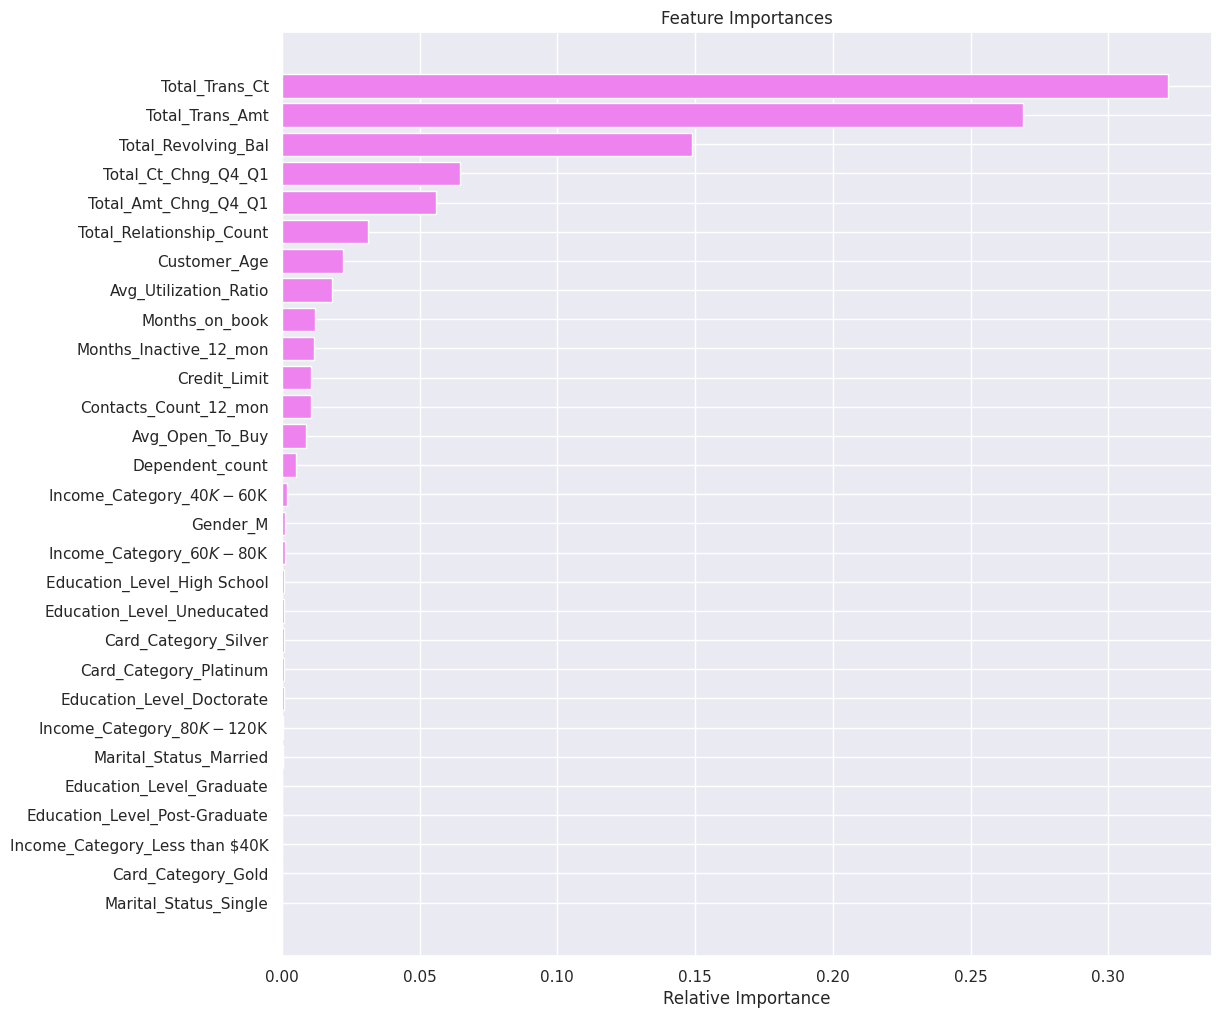

In [ ]:
feature_names=X_train.columns
importances=tuned_gbm1.feature_importances_
indices=np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)),[feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Business Insights and Conclusions


- It's crucial for the company to recognize that customers with a high total transaction count and substantial transaction amounts are more inclined to become attrited customers.

- Individuals who carry a higher total revolving balance, accumulating unpaid amounts over time, are likely to opt for a shorter stay with us rather than a long-term commitment.

- If there's a significant change in transaction count and amount from Q1 to Q4, leaning towards higher values, it signals a heightened probability of customer attrition. The company should prioritize engaging with these customers during this period.

- Customers holding a larger number of total products are more prone to leaving us as long-term patrons. The bank should consider investing more in enhancing product quality and services to foster enduring relationships with these customers.

- Customer age also plays a role in the likelihood of them leaving the bank. The bank should pay attention to customers in higher age demographics as well.

***